
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1 - Ejercicio 1

### Integrantes
- Bosch, Daniela
- Gherra, Estefanía
- Iberra, Yanina
- Mantovani, Luciano
- Palacio Pastor, Natalí

## **Resumen**

El presente trabajo contiene la resolución de dos ejercicios, con varios análisis dentro de cada uno de ellos, organizados tal como se detalla a continuación.

El primero se estructura partiendo del "interrogante general de investigación", y se ofrece un desarrollo que responde a las consignas propuestas, pretendiendo ir de lo general a lo particular, y obtener información que nos permita responder la pregunta a cada paso.

El segundo mantiene fielmente la estructuración propuesta en las consignas, desagregando en sub-ítems los aspectos a destacar según las herramientas seleccionadas para resolverlas.

# Ejercicio 1: Análisis descriptivo

Responder a la pregunta: 



## **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**



Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

**Aclaración:** Al no haber diseñado y seleccionado la muestra nosotros, y no contar por el momento con suficientes herramientas de curación u otras para detectar sesgos ocultos en los datos, un supuesto fuerte que tenemos que asumir por ahora es que la muestra es aleatoria. Es decir, que cada persona que respondió el cuestionario tuvo/tiene igual probabilidad de ser parte de la misma. Si así no lo fuera, podrían existir sesgos o errores en las estimaciones que estarán fuera de nuestro control.

Por otro lado, en los análisis realizados se hace una advertencia cuando observamos que el tamaño de alguna sub-muestra o grupo bajo estudio es considerado "pequeño" para poder arribar a una conclusión.

### Librerías y configuraciones generales

In [1]:
import io
import scipy
import matplotlib
import numpy
import pandas as pd
import seaborn

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
seaborn.set_context('talk')

# Set float format
pd.set_option('display.float_format','{:.2f}'.format)

# Set style
seaborn.set_style("darkgrid")
seaborn.set_palette('pastel') 
seaborn.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

pd.options.mode.chained_assignment = None 

### Lectura del dataset y definiciones previas

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
raw_df = pd.read_csv(url)

In [3]:
df = raw_df.copy()
df[:5]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.00,3.00,3.00,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.00,Bruto,Full-Time,53000.00,43000.00,NaN,1,1,No,No recibo bono,No,0.00,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.00,2.00,2.00,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.00,Bruto,Full-Time,79000.00,63000.00,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.00,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.00,0.00,0.00,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.00,Porcentaje de mi sueldo,Full-Time,160000.00,127000.00,NaN,3,3,Un sueldo,Performance individual,No,0.00,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN
3,Hombre,39,Argentina,Corrientes,15.00,15.00,13.00,5,Posgrado,Incompleto,Licenciatura en Sistemas,UNNE Universidad Nacional del Nordeste,"Sí, de forma particular, Sí, los pagó un emple...",Sí,Sí,SysAdmin / DevOps / SRE,"Docker, Linux, OpenStack, VMWare, Windows Server","Bash/Shell, C, CSS, HTML, Java, Javascript, PH...","jQuery, WordPress","Microsoft SQL Server, MySQL",PHPUnit,"Eclipse, Visual Studio Code",GNU/Linux,Android,"Sí, pasiva",0.00,Bruto,Full-Time,130000.00,102000.00,NaN,3,1,No,No recibo bono,No,0.00,0,En mi trabajo actual,Heterosexual,NaN,NaN,501-1000,Otras industrias,7,6,"Abono de celular, Capacitaciones y/o cursos, C...",NaN
4,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,9.00,6.00,6.00,0,Universitario,En curso,Licenciatura en Ciencias dela Computación,UBA - Universidad de Buenos Aires,No,No,Sí,Developer,Amazon Web Services,"CSS, HTML, Javascript, SQL, TypeScript","Angular, Node.js","Amazon DynamoDB, MongoDB, MySQL",Jest,Vim,macOS,Android,No,0.00,Porcentaje de mi sueldo,Full-Time,140000.00,106000.00,NaN,1,1,Menos de un sueldo,Performance individual,No,0.00,0,Jamás,Heterosexual,NaN,NaN,11-50,Servicios / Consultoría de Software / Digital,6,6,"Clases de idiomas, Horarios flexibles, Vacacio...",NaN


In [4]:
# Salario Mínimo en Argentina de Octubre 2019 a Octubre del 2020 (la encuesta es de Julio/Agosto 2020). 
# Ver detalles y referencia en la sección "2.1 Eliminación de outliers"
MIN_WAGE = float(16875)

# Frecuencia default para visualizaciones
FREQ = 10

### Funciones auxiliares

In [5]:
def remove_outlier(df_in, col_name, iqr_factor = 1.5):
    """
    IQR outliers removal 
    (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
    accept a dataframe, remove outliers, return cleaned data in a new dataframe
    see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 # interquartile range
    fence_low  = q1 - iqr_factor*iqr
    fence_high = q3 + iqr_factor*iqr
    df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    return df_inliers, df_outliers

def one_hot_encoding(df, column, separator=',', freq=FREQ):
    """
    Retorna un nuevo df con una columna por cada valor posible en 'column', 
    de acuerdo al separador. Y se queda con las columnas cuya frecuencia sea 
    mayor a 'freq'
    """
    df_one_hot = df[column]\
        .str.replace(' ', '')\
        .str.lower()\
        .str.get_dummies(sep=separator)
    for column in df_one_hot.columns:
        if (df_one_hot[column].sum() < freq):
            df_one_hot.drop(column, inplace=True, axis=1)
            df_one_hot.reset_index(drop=True, inplace=True)
    return df_one_hot

def percentile_data(df, col, percentiles):
    """
    Visualiza los percentiles de la lista 'percentiles' del dataframe 'df' para la columna 'col'.
    """
    for k in percentiles:
        percentile_k = df[col].quantile(k / 100)
        n_below = len(df[df[col] < percentile_k])
        n_above = len(df[df[col] > percentile_k])
        print('Percentil {} de la columna {}: {:.2f}'.format(k, col, percentile_k))
        print('\n')

def cured_lang_html_css(array_lang, list_filters):
    """
    función que, dado un array original y un array de filtrado, devuelve el array nuevo, 
    eliminando los elementos que estan incluidos en el array de filtrado
    """
    if any (x in array_lang for x in list_filters):
        filtered_array = [x for x in array_lang if x not in list_filters]
        filtered_array.append("html/css")
        array_lang=filtered_array
    return array_lang

def filtered_lang_html_or_css(string_of_lang, list_filters):
    """
    función que, dado un string y un array, devuelve el string filtrado, 
    eliminando los elementos que estan incluidos en el array
    """
    if any (x in string_of_lang for x in list_filters):
        array_of_lang_from_string = [x.strip() for x in string_of_lang.split(",")]
        filtered_array_from_array_of_lang = [x for x in array_of_lang_from_string if x not in list_filters]
        string_of_lang=' '.join(filtered_array_from_array_of_lang)+" HTML/CSS"

    return string_of_lang

## 1- Selección de columnas relevantes para el análisis 

Para seleccionar las columnas o variables relevantes para responder a la pregunta, comenzamos con un análisis exploratorio univariado preliminar.

Se observa un resumen de medidas de estadística descriptiva en la primera celda de código, y la cantidad de valores perdidos por variable en la segunda. 

In [6]:
df.describe(include= "all")

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
count,6095,6095.00,6095,6095,6095.00,6095.00,6095.00,6095.00,6095,6095,5796,5561,6095,6095,6095,6095,6093,6094,6094,6093,6089,6094,6095,6095,6095,6095.00,6095,6095,6095.00,5883.00,676,6095.00,6095.00,6095,6095,6095,6095.00,6095.00,5954,5912,600,2207,6095,6095,6095.00,6095.00,6094,1692
unique,3,nan,1,25,nan,nan,nan,nan,7,3,495,799,7,2,2,334,1183,1637,1371,1271,717,1097,4,4,3,nan,3,5,nan,nan,1,nan,nan,5,192,5,nan,nan,3,42,89,2,10,3,nan,nan,1916,1293
top,Hombre,nan,Argentina,Ciudad Autónoma de Buenos Aires,nan,nan,nan,nan,Universitario,Completado,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular",No,Sí,Developer,Ninguna de las anteriores,Ninguno de los anteriores,Ninguno de los anteriores,Ninguna de las anteriores,Ninguna de las anteriores,Ninguno de los anteriores,Windows,Android,No,nan,Porcentaje de mi sueldo,Full-Time,nan,nan,Mi sueldo está dolarizado,nan,nan,No,No recibo bono,No,nan,nan,Jamás,Heterosexual,Visual,No,11-50,Producto basado en Software,nan,nan,Ninguna de las anteriores,Mercado Libre
freq,5122,nan,6095,3764,nan,nan,nan,nan,4133,2907,1194,1378,2650,5211,3268,2402,744,661,1379,871,2173,903,3442,4868,4640,nan,3183,5166,nan,nan,676,nan,nan,3782,3673,2671,nan,nan,4096,4905,319,2064,1065,2200,nan,nan,828,72
mean,NaN,41.18,NaN,NaN,8.93,3.31,2.89,2.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664.04,NaN,NaN,124058.55,94907.95,NaN,2.62,2.36,NaN,NaN,NaN,10.44,2.79,NaN,NaN,NaN,NaN,NaN,NaN,7.34,7.62,NaN,NaN
std,NaN,665.72,NaN,NaN,7.16,4.37,3.42,32.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10540.52,NaN,NaN,122912.35,96862.26,NaN,0.86,0.95,NaN,NaN,NaN,12.86,2.84,NaN,NaN,NaN,NaN,NaN,NaN,2.02,2.32,NaN,NaN
min,NaN,18.00,NaN,NaN,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,1.00,1.00,NaN,1.00,1.00,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,NaN,NaN
25%,NaN,27.00,NaN,NaN,3.00,0.00,1.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,61595.00,51480.00,NaN,2.00,2.00,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,6.00,6.00,NaN,NaN
50%,NaN,31.00,NaN,NaN,7.00,2.00,2.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,96000.00,78000.00,NaN,3.00,2.00,NaN,NaN,NaN,7.00,2.00,NaN,NaN,NaN,NaN,NaN,NaN,8.00,8.00,NaN,NaN
75%,NaN,37.00,NaN,NaN,13.00,4.00,4.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,145000.00,106000.00,NaN,3.00,3.00,NaN,NaN,NaN,18.00,6.00,NaN,NaN,NaN,NaN,NaN,NaN,9.00,10.00,NaN,NaN


In [7]:
missing_values_count = df.isnull().sum()
missing_values_count

profile_gender                                     0
profile_age                                        0
work_country                                       0
work_province                                      0
profile_years_experience                           0
work_years_in_company                              0
work_years_in_current_position                     0
work_people_in_charge_of                           0
profile_studies_level                              0
profile_studies_level_state                        0
profile_career                                   299
profile_university                               534
profile_specialization_courses                     0
profile_open_source_contributions                  0
profile_programming_as_hobby                       0
work_role                                          0
tools_platform                                     2
tools_programming_languages                        1
tools_frameworks                              

**En esta primera aproximación a los datos, se observan para cada variable, en relación al total de casos**: los casos perdidos (se mencionará sólo si los hay); la cantidad de categorías de las variables con escalas nominal u ordinal (cualitativas), y su moda; y las medidas de posición y de variabilidad de los datos en las variables con escalas discretas o intervalares (cuantitativas -al menos de acuerdo a lo que está cargado y observado en esta aproximación inicial a la base-). 

Se puntualiza rápidamente lo siguiente:

**Muestra total:** 6095 personas (o respuestas).

* **Género**: amplia mayoría de hombres en la muestra.
* **Edad**: la mitad de la muestra tiene como máximo 31 años. Se observan valores extremos superiores -> limpiar si se la quiere analizar.
* **País del encuestado**: Argentina el 100% de la muestra (notar: no es país para el cual trabaja, sino que entendemos que es residencia).
* **Provincia del encuestado**: Más de la mitad: CABA (idem nota anterior).

* **Experiencia laboral en años**:  la mitad de la muestra tiene como máximo 7 años de experiencia laboral. Se observan valores extremos superiores -> limpiar si se la quiere analizar.
* **Años en la empresa**: la mitad de la muestra tiene como máximo 2 años en la empresa; un 25% de la muestra lleva entre 2 y 4 años en la empresa.
* **Gente a cargo**: Esta variable registra una dispersión muy alta -> analizar en detalle/limpiar si se la quiere seleccionar para trabajar. 
* **Nivel de estudio**: La mayoría (>60% de la muestra) respondió Universitario, pero habría 7 categorías posibles.
* **Estado del estudio**: Habría tres categorías, donde la moda para toda la muestra es "Completado", con un valor cercano al 50% de los datos. Notar: esta variable se vincula con la respuesta de la anterior.
* **Carrera**: Tiene 299 casos perdidos. Habría 495 carreras "diferentes" (revisar/analizar si se quiere utilizar). Moda: Ing.Sist.Inf. con aprox. 1/5 del total de respuestas no vacías.
* **Universidad**: 534 casos perdidos. Habría 799 universidades "diferentes" (revisar/analizar si se quiere utilizar). Moda: UTN con 1378 casos.
* **Cursos**: Habría 7 categorías de rta. Más de 1/3 de la muestra respondió "Si particular".
* **Contribuciones open source**: Un poco más de 5/6 de la muestra dijo "No".
* **Programa como Hobby**: Un poco más de la 1/2 de la muestra dijo que "Si".
* **Rol**: Habría 334 roles (revisar/analizar si se quiere utilizar). Un poco más de 1/3 de la muestra son desarrolladores (Moda).
* **Plataformas**: Habría 1.183 plataformas distintas. La Moda fue "Ninguna de las anteriores" con 744 respuestas. Es decir, hay mucha variabilidad y no es buen indicador que la moda sea "ninguna de las anteriores"-> Necesita trabajo de análisis detallado, depuración, agrupación de categorías si se la quiere utilizar para trabajar. Tiene sólo dos casos perdidos.
* situación similar en variables: **Lenguajes de programación** (1.637 categ. y 661=Ninguno), **framework** (1.371 categ. y 1379=Ninguna), **data bases** (1.271 categ. y 871=Ninguna), **qa testing** (717 categ. y 2.173=Ninguna), **IDES** (1.097 categ. y 903=Ninguna) -> Variables que necesitan análisis. Los casos perdidos oscilan entre 1 y 6 como máximo (insignificantes).
* **Sistema Operativo Pc**: Habría 4 categorías. Más de la mitad de la muestra respondió "Windows".
* **Sistema Operativo Celular**: Habría 4 categorías. Más de 2/3 de la muestra respondió "Android".
* **Disponibilidad ante llamado**: Más de 2/3 de la muestra respondió "NO".
* **Salario por Disponibilidad** Prácticamente son valores extremos -> Analizar si se la quisiera utilizar (¿será porque son trabajos en dólares?, ¿porque tienen cargos altos/directivos/personal a cargo? ¿otras razones? ¿errores?).
* **Tipo de salario por la condición "Disponibilidad"**: Más de la mitad de la muestra respondió "como % del sueldo" (habría 3 categorías de respuestas.)
* **Tipo de contrato**: Más de 5/6 de la muestra respondió "Full Time". Habría 5 categorías diferentes.
* **Salario Bruto**, Variable con con alta variabilidad y extremos -> Analizar en detalle si se la quiere utilizar.
  * **Salario Neto**, similar a Salario Bruto en cuanto a distribución, y además tiene 212 casos perdidos. -> Analizar para usar.
* **Sueldo en dolares**: es categórica. Sólo respondió un 10% aprox. de la muestra (676 casos), aparentemente seleccionando una única categoría = "Mi sueldo está dolarizado". El resto son valores nulos (5419).
* **Satisfacción**: Notar -> categórica ordinal (respuesta en números estilo escala).
* **Comparación salaro con último semestre**: respuesta en números que parece ser categórica -> investigar la definición de la variable o pregunta realizada en la encuesta en caso de querer seleccionarla para trabajar. 
* **Tiene bono el salario**: Más de la mitad de la muestra dijo "NO".
* **Bono vinculado a**: Más de la mitad dijo "No recibo bono". Pero habría 192 categorías diferentes (revisar/analizar si se la quiere utilizar). 
* **Ajuste por inflación al salario en 2020**: Muestra 5 Categorias, y menos de la 1/2 dijo "NO".
* **% de ajuste por inflación al salario en 2020**: Un 25% de la muestra respondió que el ajuste por inflación fue entre 0% y 7%. Otro 25% de la muestra recibió un ajuste por inflación entre 7% y 18%. Notar: La variable tiene valores extremos superiores, analizar y limpiar si se la quiere utilizar.
* **% de ajuste por inflación del ultimo mes**: Un 25% de la muestra respondió haber tenido un ajuste del 2% al 6%. Otro 25% de la muestra respondió que su ajuste por inflación fue del 6% al 8%.
* **Situaciones de violencia**: Habría 3 categorias; tiene 141 valores nulos. Moda: "jamás" (con una proporción aprox. de 4/6 de las respuestas).
* **Orientacion sexual**: Habría 42 categorias, tendría 183 datos faltantes. Moda: heterosexual (con proporción aprox. de 5/6). 
* **Discapacidad**: registra 5.495 valores faltantes; 319 casos del total de 600 respondieron "visual".
* **La discapacidad genera problemas de contratación**: registra 3.888 valores faltantes; la mayoría de los que respondieron dijeron que "NO" (2.064 casos del total de 2.207 respuestas).
* **Número de empleados de la empresa**: Cargada como categórica con aparentemente 10 intervalos. Moda: Entre 11 y 50 empleados (con una proporción aproximada de 1/6 del total).
* **Actividad principal de la empresa**: Tendría 3 categorías. Moda: Producto basado en Software (aproximadamente 1/3 del total de casos).
* **Recomendación de la empresa**: Parece ser una variable con una escala de puntuaciones que van del 1 al 10. Su media es 7,34 y su desviación estándar 2,02.
* **Políticas de diversidad de la empresa**: Parece ser una variable con una escala de puntuaciones que van del 1 al 10. Su media es 7,62 y su desviación estándar 2,32.
* **Beneficios extra de la empresa**: Se tienen 1.916 categorías de respuestas diferentes. Moda: "Ninguna de las anteriores" con 828 casos. Tendría sólo 1 caso perdido, pero claramente es una variabla que habría que analizarla y mejorar para poderla utilizar.
* **Mejor empresa de la ciudad**: Registra 4.403 valores faltantes (sólo 1.692 respuestas), con 1.293 valores diferentes. Moda: "Mercado Libre" (con muy baja proporción 72/1.692).


En función de este pantallazo general de la base de datos, y de la pregunta de investigación, seleccionamos las siguientes variables para analizar:

- `tools_programming_language` (**"lenguajes de programación"**): Es nuestra variable objetivo.
- `salary_monthly_NETO` (**"salario mensual neto"**): Es nuestra segunda variable objetivo.

Notar: La razón de por qué utilizamos el salario NETO y no el BRUTO está en el Ejercicio 2.b)

El resto de las variables de la lista 'relevant_columns' que se detalla a continuación se utilizarán para observar posibles relaciones entre las distribuciones, ya que consideramos que pueden influenciar de alguna manera en el estudio de la asociación entre el salario y los lenguajes. También algunas nos servirán para realizar los análisis de salarios sobre sub-poblaciones, tal como fuera solicitado.

In [8]:
relevant_columns = [
    'tools_programming_languages', 
    'salary_monthly_NETO', 
    'salary_monthly_BRUTO',
    'tools_work_pc_os',
    'work_contract_type',
    'tools_frameworks',
    'profile_years_experience',
    'salary_satisfaction',
    'company_main_activity',
    'salary_in_usd',
    'work_role',
    'work_years_in_company',
    'profile_gender',
    'profile_age',
    'profile_studies_level'
]

Filtramos el dataframe para quedarnos con las columnas de interés.

In [9]:
df=df[relevant_columns]

## 2- Selección de filas relevantes para el análisis

Para esta etapa procedemos a inspeccionar los datos, para su posterior filtrado.

### 2.1 Limpieza de datos

#### **Manejo de valores nulos en las variables de interés**



In [10]:
# salary_monthly_NETO
print("Cantidad de valores nulos en la variable salary_monthly_NETO: {}".format(
    len(df[df['salary_monthly_NETO'].isnull()])), "\n")
df= df[~df['salary_monthly_NETO'].isnull()]
df.reset_index(drop=True, inplace=True)
print("Cantidad de valores nulos en la variable salary_monthly_NETO luego eliminar los nulos: {}".format(
    len(df[df['salary_monthly_NETO'].isnull()])), "\n")

#tools_programming_languages
print("Cantidad de valores nulos en la variable tools_programming_languages: {}".format(
    len(df[df['tools_programming_languages'].isnull()])), "\n")
# Reemplazaremos los valores null de 'tools_programming_languages' por 'Ninguno'
df.tools_programming_languages.replace(numpy.NaN, 'Ninguno', inplace=True)
print("Cantidad de valores nulos en la variable tools_programming_languages luego del reemplazo: {}".format(
    len(df[df['tools_programming_languages'].isnull()])), "\n")

Cantidad de valores nulos en la variable salary_monthly_NETO: 212 

Cantidad de valores nulos en la variable salary_monthly_NETO luego eliminar los nulos: 0 

Cantidad de valores nulos en la variable tools_programming_languages: 1 

Cantidad de valores nulos en la variable tools_programming_languages luego del reemplazo: 0 



- Se decide eliminar los 212 casos con valores faltantes de la variable `'salary_monthly_NETO'` ya que representan sólo un 3.47% de la muestra.
- Se reemplaza el único dato faltante de la variable `'tools_programming_languages'` por el valor "Ninguno".

#### **Eliminación de Outliers**

En la variable de salario elegida, luego del estudio que se resumirá debajo, decidimos eliminar outliers que distorcionan la distribución sin sentido o justificación empírica (considerando la información que manejamos hasta el momento).

**Análisis de rangos y percentiles**: 

Verificación del rango de valores de la variable `'salary_monthly_NETO'` previo a cualquier eliminación de casos.

In [11]:
df['salary_monthly_NETO'].describe()

count      5883.00
mean      94907.95
std       96862.26
min           1.00
25%       51480.00
50%       78000.00
75%      106000.00
max     2080000.00
Name: salary_monthly_NETO, dtype: float64

Coeficiente de variación (en %) del Salario Neto.

In [12]:
print("Coeficiente de variación salario neto: {:.2f}% \n".format(
    scipy.stats.variation(df.salary_monthly_NETO)*100))# Sin los nulos

Coeficiente de variación salario neto: 102.05% 



Analizamos diferentes percentiles de la distribución de `'salary_monthly_NETO'`. Con esto se busca determinar en qué momento la distribución hace un salto de valor significativo en términos "de salario neto absoluto", pero que a la vez es insignificativo en terminos de proporción o frecuencia de casos en relación al total. 


In [13]:
percentiles = [90, 95, 96, 97, 98, 99]
percentile_data(df, 'salary_monthly_NETO', percentiles)

Percentil 90 de la columna salary_monthly_NETO: 150000.00


Percentil 95 de la columna salary_monthly_NETO: 210000.00


Percentil 96 de la columna salary_monthly_NETO: 250720.00


Percentil 97 de la columna salary_monthly_NETO: 300000.00


Percentil 98 de la columna salary_monthly_NETO: 370000.00


Percentil 99 de la columna salary_monthly_NETO: 491800.00




**Observaciones:**

Para la variable `'salary_monthly_NETO'` vemos que:

**- En el análisis de rangos y percentiles**: Como se observa en la estadística descriptiva de la variable sin depurar, los 5.883 casos con respuesta tienen un salario neto promedio igual a \$94.907,95 y una desviación estándar de \$96.862,26; lo que implica un Coeficiente de Variación muy alto para esta variable (102%).Esta variación también es visible en su rango total, que tiene como mínimo el valor \$1 (sin sentido empírico para el análisis), y como valor máximo \$2.080.000 (lo cual podría estar explicado por un error de carga, o por la influencia de alguna otra variable de la muestra). 

**- En la parte inferior de la distribución**: valores inferiores tan bajos como \$1 o \$100, pueden haber sido ingresados erróneamente de forma involuntaria (omitiendo ceros por ejemplo, o por haber puesto el "." como separador de miles, y ésto luego la computadora lo tomó como un valor menor: \$100.000 -> \$100). También estos valores extremos en la parte inferior pueden haber sido completados con valores irrisorios en la práctica a propósito, por no querer responder a la pregunta sobre ingresos (suele ser un tema sensible de investigar). Otra posible causa podría estar relacionada con el hecho de haber ingresado en la celda un valor de salario correspondiente al "valor absoluto en dólares", y no a su valor equivalente (convertido por el tipo de cambio del momento) en pesos argentinos. Por último, habíamos visto que había varios casos "nulos" o sin respuesta al comienzo en el paneo general, lo cual puede deberse a que los encuestados no quieren informar su sueldo o incluso a un desconocimiento de los conceptos específicos Neto (y Bruto).

**- En la parte superior de la distribución**: valores muy grandes pueden corresponder a puestos jerárquicos, o con personas a cargo, o personas que cobran sueldos dolarizados, entre otros. Como ya se explicó, con el método de visualizar los percentiles, vemos que el 97% de los salarios están por debajo de \$300.000 argentinos. Y luego los percentiles 98% y 99% pegan un salto a \$370.000 y \$491.800 respectivamente, siendo el valor máximo o percentil 100% \$2.080.000. 

**- Como no contamos con mayor información para tratar cada uno de éstos casos, decidimos:** eliminar outliers con el método del Rango Intercuartílico con un factor de 3.5 (lo que implica en los hechos no considerar sueldos superiores a \$300.000, quedándonos con el cuantil 97); y adoptar como criterio efectivo para el límite inferior del rango, el salario mínimo establecido por ley \$16.875, vigente durante el periodo de la encuesta (*).

(*) Fuente Salario Mínimo:

https://www.boletinoficial.gob.ar/detalleAviso/primera/215268/20190902

https://www.boletinoficial.gob.ar/detalleAviso/primera/215373/20190903

https://www.argentina.gob.ar/trabajo/buscastrabajo/conocetusderechos/salario


**Eliminación de outliers con el método de cuantiles con un coeficiente de 3.5**

In [14]:
df_inliers, df_outliers = remove_outlier(df, 'salary_monthly_NETO', 3.5)
print("Tamaño del dataset antes de remover outliers: %i \n" % len(df))
print("Cantidad de outliers eliminados: {} ({:.2f}%) \n".format(
    len(df_outliers), len(df_outliers)/len(df)*100))
print("Some basic statistical:")
df= df_inliers
df['salary_monthly_NETO'].describe()

Tamaño del dataset antes de remover outliers: 5883 

Cantidad de outliers eliminados: 183 (3.11%) 

Some basic statistical:


count     5700.00
mean     81995.65
std      46605.21
min          1.00
25%      50000.00
50%      75000.00
75%     102000.00
max     290000.00
Name: salary_monthly_NETO, dtype: float64

**Observaciones:**

- De los 5.883 registros (sin nulos), se eliminó un 3% (183 registros), correspondientes a valores extremos en la parte superior. Por lo tanto tenemos ahora 5.700 registros en total.

- Vemos que el valor máximo de la variable `'salary_monthly_NETO'` pasó de \$2.080.000 a \$290.000 (con lo cual el rango se mantiene por debajo del quantile 97% que habíamos analizado anteriormente).
- Aún tenemos valores extremos en el rango inferior (el mínimo sigue siendo \$1), que depuraremos en el siguiente punto.

**Eliminación registros por debajo del salario mínimo \$16875**

In [15]:
# Registros a eliminar
df_outliers_lower_limit = df.query('salary_monthly_NETO < @MIN_WAGE')

# Registros a mantener
df = df.query('salary_monthly_NETO >= @MIN_WAGE')
df.reset_index(drop=True, inplace=True)

print("Cantidad de outliers eliminados: {} ({:.2f}%) \n".format(
    len(df_outliers_lower_limit),
    len(df_outliers_lower_limit)/len(df)*100)
)

df['salary_monthly_NETO'].describe()

Cantidad de outliers eliminados: 240 (4.40%) 



count     5460.00
mean     85474.63
std      44484.20
min      17000.00
25%      54000.00
50%      78000.00
75%     105000.00
max     290000.00
Name: salary_monthly_NETO, dtype: float64

**Observaciones:**

- De los 5.700 registros que teníamos, se liminaron en este paso el 4.40% (240 registros), correspondientes a valores extremos en la parte inferior (sin sentido empírico). 

- **Por lo tanto tenemos ahora 5.460 registros en total.**

- La desviacion estandar ahora toma un valor de \$44.484,20, reduciendo significativamente el Coeficiente de Variacion de la muestra completa, de un 102% al 45%.

- Vemos que el valor máximo de la variable `'salary_monthly_NETO'` se mantuvo en \$290.000 y que el mínimo pasó de \$1 a \$17.000 (casos por encima del salario mínimo).

#### **Exportamos el dataframe sin outliers a un csv.**

El siguiente código permite exportar el dataframe sin outliers, ni valores nulos en la variable `'salary_monthly_NETO'`. 
Se deberá descomentar y cambiar en la variable "path" por una carpeta existente en el drive a donde se corra el notebook.
Luego en el entregable 1, parte 2, se trabajará con éste csv "limpio".

In [16]:
# Import Drive API and authenticate.
#from google.colab import drive

# Mount your Drive to the Colab VM.
#drive.mount("/content/gdrive")

In [17]:
# Write the DataFrame to CSV file. Change path for existing folder in your drive.
#path='/content/gdrive/MyDrive/DiploDatos2021/AyVD/data/'
#df.to_csv(path+'dataset_without_outliers.csv')

### 2.2 Análisis de sueldos dolarizados

Veremos en nuestra muestra la distribución de aquellos casos con sueldos dolarizados, para ver si restringimos el análisis a una sub-población.

La variable `'salary_in_usd'`, en el dataset depurado: 
- tiene solamente una categoría: 'Mi sueldo está dolarizado', que registraba  676 casos.
- tiene 5.419 valores faltantes (esa cantidad de personas no ingresaron valor en éste campo).

Vale notar que del dataset original se eliminaron casos al depurar los outliers de la variable sueldo neto, por lo que los números ut-supra pueden variar ligeramente.

Analizaremos la variable `'salary_in_usd'`, para poder ver su frecuencia en el dataset actual, y luego observar con ella las diferentes distribuciones del salario neto en $ARS, condicionado a si el sueldo neto recibido está dolarizado o no. 

Creamos una variable categórica "salary_is_usd_cat", que refleja si los salarios están dolarizados o no y graficamos su frecuencia.

Tabla de Frecuencias

 Mi sueldo es en pesos        4993
Mi sueldo está dolarizado     467
Name: salary_is_usd_cat, dtype: int64 



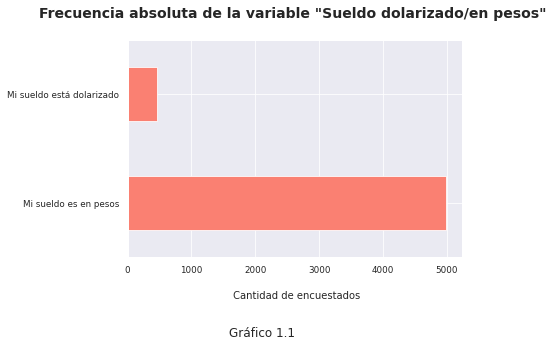

In [18]:
df['salary_is_usd_cat'] = df.salary_in_usd
# Reemplazamos los valores na de la columna salary_in_usd
df['salary_is_usd_cat'].fillna('Mi sueldo es en pesos', inplace=True)

fig = plt.figure(figsize=(6, 4))
df['salary_is_usd_cat'].value_counts()\
    .plot.barh(color = "salmon")\
    .set_title('Frecuencia absoluta de la variable "Sueldo dolarizado/en pesos" \n ', fontsize=14, weight='bold')
plt.xlabel("\n Cantidad de encuestados", fontsize=10)
plt.annotate(
    'Gráfico 1.1', 
    xy = (0.5, -0.35), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)
print("Tabla de Frecuencias\n\n", df['salary_is_usd_cat'].value_counts(), "\n")

Vemos ahora su distribución.

Text(0.5, -0.25, 'Gráfico 1.2')

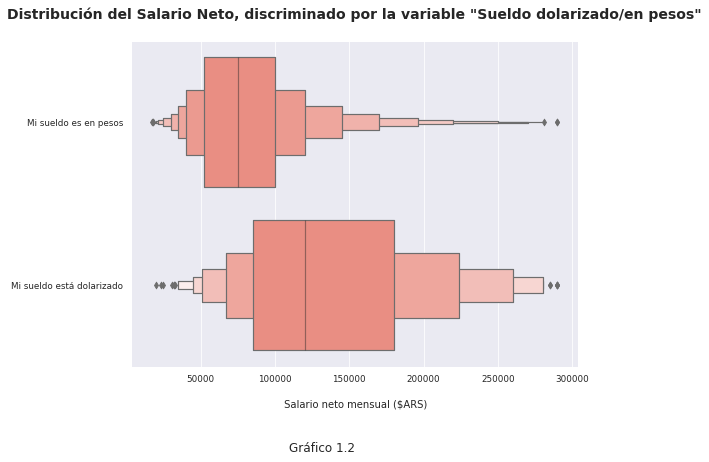

In [19]:
fig = plt.figure(figsize=(8, 6))
g = seaborn.boxenplot(
    data=df, 
    x='salary_monthly_NETO',
    y='salary_is_usd_cat', 
    color='salmon'
)
plt.title('Distribución del Salario Neto, discriminado por la variable "Sueldo dolarizado/en pesos"\n', fontsize=14, weight='bold')
plt.ylabel("")
plt.xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
plt.annotate(
    'Gráfico 1.2', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

**Observaciones:**

- Del Gráfico 1.1 y su tabla de frecuencias podemos ver que la mayoría de las 
personas encuestadas (92% = 4.993/5.460) cobran su sueldo neto en pesos argentinos, y sólo el 8% de la muestra depurada (467 personas) lo cobran en dólares. Si bien la cantidad de personas que cobran en dólares es significativamente menor, es un buen número en sí mismo para analizarlo como grupo.

- Al comparar las distribuciones de sueldo neto discriminadas o condicionadas según la moneda en que lo cobran (Gráfico 1.2), se podría decir que se trata de dos ´subpoblaciones´ distintas (observar las diferentes medidas de posición: medianas, cuantiles, valores extremos y rangos). En particular, la distribución de los sueldos en pesos tiene menor mediana y menor variación, que la distribución de los sueldos en dólares.

- Se decide dejar la población completa para el análisis sucesivo, y se analiza en la sección 3.8 la sub-población "no dolarizados".

### 2.3 Análisis de trabajos Full-Time vs otros tipos de contrato

Nos interesa ver si hay "diferentes sub-poblaciones" en lo que respecta a las distribuciones de sueldos netos, considerando el tipo de contrato en tres situaciones distintas:

1. Para el total de trabajadores (sin discriminar si cobran en $ARS o USD).

2. Sólo para los que cobran en dólares.

3. Sólo para los que cobran en pesos argentinos.

Veamos la distribución de Salarios Netos para los diferentes tipos de contratos mediante boxplots.

Text(0.5, -0.6, 'Gráfico 1.3')

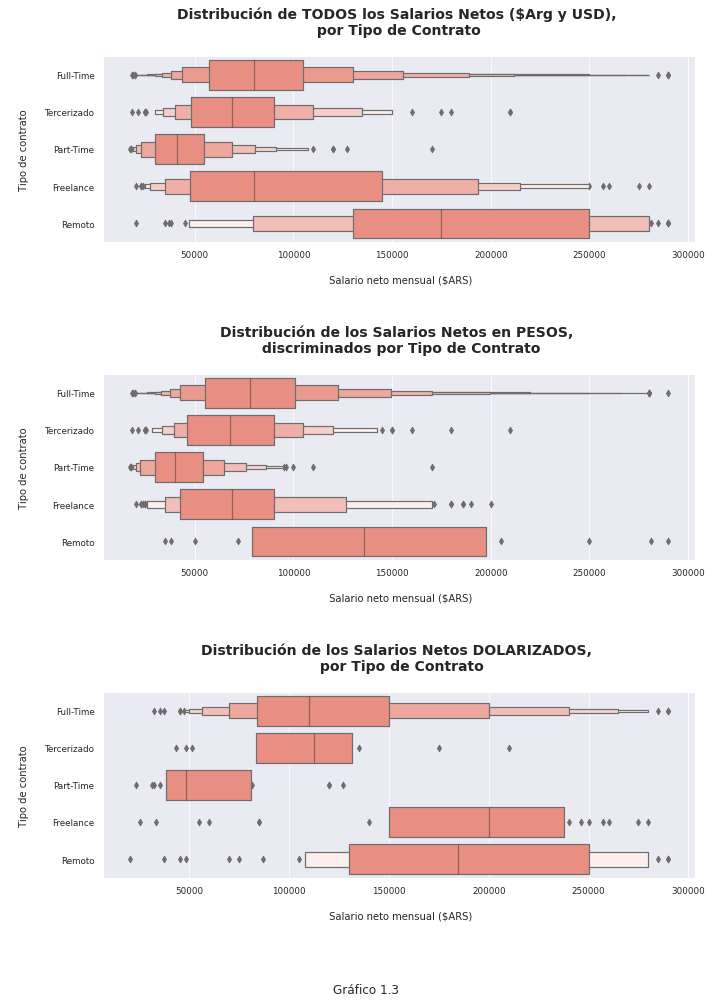

In [20]:
df['work_contract_type'] = df['work_contract_type'].str.split(" ").str[0]
order = ['Full-Time', 'Tercerizado', 'Part-Time', 'Freelance', 'Remoto']

fig, axes = plt.subplots(figsize=(10, 13), nrows=3)

# Boxplot de toda la muestra (salarios dolarizados y no)
seaborn.boxenplot(
    data=df, 
    x='salary_monthly_NETO',
    y='work_contract_type', 
    color='salmon', 
    ax=axes[0],
    order=order
)
axes[0].set_title("Distribución de TODOS los Salarios Netos ($Arg y USD), \n por Tipo de Contrato \n", fontsize=14, weight='bold')
axes[0].set_xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
axes[0].set_ylabel("\n Tipo de contrato \n", fontsize=10)

# Boxplot de los salarios en pesos
seaborn.boxenplot(
    data=df[df['salary_is_usd_cat'] == 'Mi sueldo es en pesos'], 
    x='salary_monthly_NETO',
    y='work_contract_type', 
    color='salmon', 
    ax=axes[1],
    order=order
)
axes[1].set_title("Distribución de los Salarios Netos en PESOS, \n discriminados por Tipo de Contrato\n", fontsize=14, weight='bold')
axes[1].set_xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
axes[1].set_ylabel("\n Tipo de contrato \n", fontsize=10)

# Boxplot de los salarios en dólares
seaborn.boxenplot(
    data=df[df['salary_is_usd_cat'] == 'Mi sueldo está dolarizado'], 
    x='salary_monthly_NETO',
    y='work_contract_type', 
    color='salmon',
    ax=axes[2],
    order=order
)
axes[2].set_title("Distribución de los Salarios Netos DOLARIZADOS, \n por Tipo de Contrato\n", fontsize=14, weight='bold')
axes[2].set_xlabel("\n Salario neto mensual ($ARS)", fontsize=10)
axes[2].set_ylabel("\n Tipo de contrato \n", fontsize=10)

fig.tight_layout(h_pad=4)
plt.annotate('Gráfico 1.3', xy = (0.5, -0.6), xycoords='axes fraction', ha='right', va='center', fontsize=12)

**Observaciones:**

- En los tres casos graficados: Total, Sólo pesos, Sólo dolar, se observa lo esperado. La distribución de sueldos Full-Time está más a la derecha (tiene valores en general mayores) que los trabajadores Part-Time. También es consecuente con lo ya analizado en relación a que la distribución en dólares Full-Time y Part-Time es mayor a la de pesos en ambos tipos de contratos (aunque habría que tener recaudos al ver las distribuciones en dólares porque parecen mostrar pocos casos, por las formas de sus boxplot -debajo chequearemos los tamaños en una tabla de frecuencias-).

- Los otros tipos de contratos (Remoto, Tercerizado y Freelance) muestran mayores diferencias entre las distribuciones en pesos y en dólares (sobretodo Freelance). Pero por las formas de los boxplot, habría que observar mejor la cantidad de casos, pues esto podría estar afectando su variabilidad, y no ser muy representativo de un comportamiento general de estos subgrupos.


Obtengamos algunas métricas para observar con mayor detalle los tamaños de cada sup-población.


In [21]:
# Personas por modalidad de trabajo
print("Tabla de Frecuencias Absolutas (Personas por Tipos de Contratos, sin agrupar):")
display(df.work_contract_type.value_counts())
print("\nCantidad de valores nulos: ", len(df[df['work_contract_type'].isnull()]), "\n", "\n") # No hay valores nulos.

# % de personas por modalidad de trabajo
print("Agrupación de personas por categorías de contratos: ")
full_time = df.work_contract_type.isin(['Full-Time'])
print("Full-Time: {} ({:.2f}%)".format(len(df[full_time]), len(df[full_time])/len(df)*100))
part_time = df.work_contract_type.isin(['Part-Time'])
print("Part-Time: {} ({:.2f}%)".format(len(df[part_time]), len(df[part_time])/len(df)*100))
otros=df.work_contract_type.isin(['Tercerizado', 'Freelance', 'Remoto'])
print("Otros: {} ({:.2f}%)".format(len(df[otros]), len(df[otros])/len(df)*100), "\n")

# Comparamos los salarios en base a la mediana
full_time_median = df[full_time].salary_monthly_NETO.median()
part_time_median = df[part_time].salary_monthly_NETO.median()
otros_median = df[otros].salary_monthly_NETO.median()
print("Mediana de los salarios Full-Time: ", full_time_median)
print("Mediana de los salarios Part-Time: ", part_time_median)
print("Mediana de los salarios Otros contratos: ", otros_median)

Tabla de Frecuencias Absolutas (Personas por Tipos de Contratos, sin agrupar):


Full-Time      4787
Part-Time       273
Tercerizado     193
Freelance       131
Remoto           76
Name: work_contract_type, dtype: int64


Cantidad de valores nulos:  0 
 

Agrupación de personas por categorías de contratos: 
Full-Time: 4787 (87.67%)
Part-Time: 273 (5.00%)
Otros: 400 (7.33%) 

Mediana de los salarios Full-Time:  80000.0
Mediana de los salarios Part-Time:  41000.0
Mediana de los salarios Otros contratos:  80000.0


**Observaciones:**

- Al realizar la agrupación de categorías de contratos, podemos ver más claramente las tres "subpoblaciones" de contratos: "Full-Time", "Part-Time" y "Otros". Examinando los valores  calculados para sus medianas, se observan claramente las diferencias entre los grupos "Full-Time" y "Part-Time" (doble de salario mediano en el primero respecto del segundo, como era de esperar).

- Se aprecia además que la distribución de los "Otros" tipos de contratos (reúne Freelance, Remoto y Tercerizado) tiene una mediana similar a los "Full-Time".

- Se mantienen las tres subpoblaciones en el análisis, para poder diferenciar más adelante por el subgrupo deseado en la sección 3.9.

## 3- Análisis de métricas

- Nuestra "población" (en realidad para ser precisos, nuestra muestra o conjunto de datos total) serán todas las personas encuestadas con un salario Neto mayor que al salario mínimo (i.e > \$16.875) y menor al quantile 97% (\$290.000) => 5.460 trabajadores del sector TI.
 
- Utilizaremos visualizaciones para aproximarnos inicialmente a los datos y estadísticas descriptivas más precisas cuando necesitemos mayor detalle para comparar.

- Trabajaremos inicialmente caracterizando la variable lenguajes de programación, para luego ver análisis específicos de posibles asociaciones entre ella y los salarios.

#### 3.1 Análisis de la variable lenguajes de programación

La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`. Sus valores son strings con los lenguajes seleccionados separados por comas.

In [22]:
# Valores de lenguajes d eprogramación ingresados por los encuestados
df.tools_programming_languages.value_counts()

Ninguno de los anteriores                   597
Ninguno                                     301
Python                                      151
SQL                                         149
Java                                        142
                                           ... 
C++, C#, CSS, HTML, Javascript, PHP, SQL      1
Go, PHP, Visual FoxPro                        1
Powersheell                                   1
Groovy, HTML, Java, Javascript                1
Bash/Shell, Go, Java, Python, Ruby            1
Name: tools_programming_languages, Length: 1498, dtype: int64

**Observaciones:**

- Como se vio en la exploración inicial (sección 1), hay más de mil valores diferentes ingresados en el campo `tools_programming_languages`, donde la moda era "Ninguno".

- Debido a que los usuarios ingresaron como lenguaje uno o más valores, separados por coma y de texto libre, debemos buscar la manera de normalizarlos, para quedarnos con una lista de aquellos identificados como válidos, para luego poder procesar y analizar.

#### 3.2 Conversión de cada lenguaje a variables categóricas (One hot encoding)

Con ésta técnica tendremos el mismo dataframe con nuevas columnas (una por cada lenguaje identificado, o los N más frecuentes) donde asignaremos valores binarios.
Entonces alguien que utiliza sólo Python va a tener un verdadero (equivalente a un 1) en esa columna y un falso en Java (0), SQL (0), etc. De esta manera iremos construyendo una matriz.

In [23]:
# Convertimos cada lenguaje en una columna con 0 o 1
# Nos quedamos con las columnas cuya frecuencia sea mayor a 10
print("Tamaño del dataset: %i \n" % len(df))
df_one_hot = one_hot_encoding(
    df, 
    'tools_programming_languages', 
    separator=',', 
    freq= 10
)

# Eliminamos las columnas 'ninguno' y 'ningunodelosanteriores' ya que no aportan 
# al análisis de lenguajes
df_one_hot.drop(columns=['ninguno','ningunodelosanteriores'], axis=1, inplace=True)
df_one_hot.reset_index(drop=True, inplace=True)
print("Tamaño del nuevo dataframe df_one_hot: ", df_one_hot.shape, "\n")

# Concatenamos ambos dataframes (el df y el df_one_encoding) para agregar las columnas de cada lenguaje
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, df_one_hot], axis=1)
df.reset_index(drop=True, inplace=True)
print("Tamaño del dataframe agregando una columna por cada lenguaje: ", df.shape, "\n")
df.head(3)

Tamaño del dataset: 5460 

Tamaño del nuevo dataframe df_one_hot:  (5460, 35) 

Tamaño del dataframe agregando una columna por cada lenguaje:  (5460, 51) 



,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,tools_work_pc_os,work_contract_type,tools_frameworks,profile_years_experience,salary_satisfaction,company_main_activity,salary_in_usd,work_role,work_years_in_company,profile_gender,profile_age,profile_studies_level,salary_is_usd_cat,.net,abap,actionscript,apex,assembler,bash/shell,c,c#,c++,cobol,css,dart,delphi,go,groovy,html,java,javascript,kotlin,matlab,objective-c,perl,php,pl/sql,powershell,python,r,ruby,rust,scala,smalltalk,sql,swift,typescript,vba
0,Ninguno,43000.00,53000.00,GNU/Linux,Full-Time,Ninguno,3.00,1,Servicios / Consultoría de Software / Digital,NaN,Consultant,3.00,Mujer,26,Universitario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"HTML, Javascript, Python",63000.00,79000.00,GNU/Linux,Full-Time,"Django, jQuery",5.00,2,Otras industrias,NaN,Developer,2.00,Hombre,29,Universitario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Ninguno,127000.00,160000.00,Windows,Full-Time,Ninguno,2.00,3,Otras industrias,NaN,Infosec,0.00,Mujer,22,Secundario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Observaciones:**

- Tenemos ahora 35 valores de "lenguales de programación", los que tienen frecuencia mayor a 10 (i.e. 35 columnas con 0 y 1, se conserva una fila por encuestado).

#### 3.3 Ocurrencias de cada lenguaje, selección de los más populares.

- Las respuestas sobre lenguajes de programación no son excluyentes, es decir, puede haber más de un lenguaje por persona relevada. 

- Los valores de frecuencia presentados debajo para cada lenguaje, cuentan la cantidad de respuestas por lenguaje, iterando el cálculo sobe el total de observaciones de la muestra (5.460).

- Vale advertir que la sumatoria total de ocurrencias (Freq) puede ser superior al total de participantes de la encuesta. 

- Sólo se consideran en el análisis los lenguajes cuya frecuencia de respuestas es mayor a 10.
  
- En la tabla a continuación sólo se muestran los 10 primeros lenguajes del ranking de "popularidad" (más nombrados/ utilizados).

In [24]:
# Tabla de frecuencias de lenguajes
lang_columns = df_one_hot.columns
lang_freq = df[lang_columns].sum().sort_values(ascending=False).reset_index()
lang_freq = lang_freq.rename(columns={'index': 'Language', 0: 'Freq'})
lang_freq[:10]

,Language,Freq
0,javascript,2209
1,sql,1950
2,html,1647
3,java,1326
4,python,1315
5,css,1101
6,bash/shell,903
7,php,790
8,.net,737
9,typescript,680


In [25]:
# Total de ocurrencias de lenguajes
len_freq = lang_freq['Freq'].sum()
print("Total de ocurrencias de lenguajes:", len_freq, "\n")
# Cantidad de ocurrencias de los primeros 10 lenguajes más frecuentes
print("Porcentaje de ocurrencias de los primeros 10 lenguajes más frecuentes: {:.2f}%".format(lang_freq['Freq'][:10].sum()/len_freq*100))

Total de ocurrencias de lenguajes: 15409 

Porcentaje de ocurrencias de los primeros 10 lenguajes más frecuentes: 82.15%


**Observaciones:**

* Se puede visualizar en la tabla de frecuencias que "Javascript" es el lenguaje más popular (2.209 personas lo nombraron/utilizan) del total de 5.460 encuestados/as en el sector TI de Argentina.

* Luego le siguen en nivel de popularidad "SQL", "HTML" y "Java".

* "Python" ocupa el quinto lugar del ranking de ocurrencias, siendo nombrado por  1.315 personas de las 5.460 personas que constituyen la muestra total.

* Si se suman todas las respuestas de lenguajes utilizados (con frecuencia mayor a 10), brindadas por las 5.460 personas en estudio, se obtiene un total de 15.409 ocurrencias de lenguajes.

* Los 10 primeros lenguajes según su ranking de popularidad, concentran el 82,15% de las 15.409 respuestas totales brindadas por lo trabajadores TI de Argentina.

* En el gráfico de barras de abajo se representa el ranking de lenguajes según su popularidad, medida ésta por la cantidad de respuestas acumuladas por cada uno de ellos. 



[Text(0, 0, '0'),
 Text(0, 0, '500'),
 Text(0, 0, '1000'),
 Text(0, 0, '1500'),
 Text(0, 0, '2000'),
 Text(0, 0, '2500')]

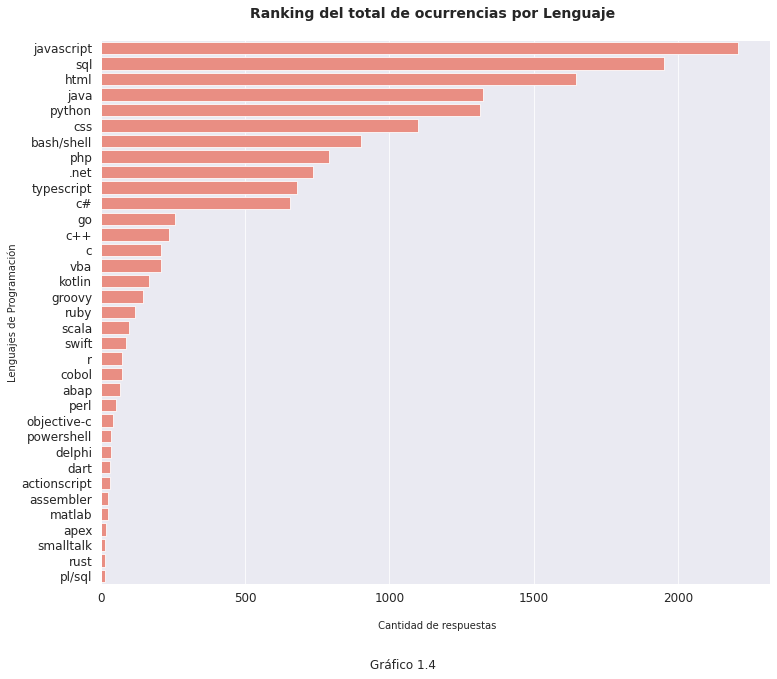

In [26]:
# Gráfico de distribución de ocurrencias de lenguajes
plt.figure(figsize=(12, 10))
ax = seaborn.barplot(x='Freq', y='Language', data=lang_freq, color="salmon") 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Ranking del total de ocurrencias por Lenguaje \n", fontsize=14, weight='bold')
plt.xlabel("\n Cantidad de respuestas", fontsize=10)
plt.ylabel("Lenguajes de Programación", fontsize=10)
plt.annotate('Gráfico 1.4', xy = (0.5, -0.15), xycoords='axes fraction', ha='right', va='center', fontsize=12)
vals = ax.get_xticks()
ax.set_xticklabels(['{:.0f}'.format(x) for x in vals])

#### 3.4 Lenguajes de programación más populares, en subpoblaciones con  "mejores" y "peores" salarios.

* En la tabla siguiente, se muestra un ranking de los lenguajes según su popularidad (sumatoria de respuestas de cada uno), pero sólo para la subpoblación de trabajadores que tienen un "salario neto igual o superior a su mediana en toda la distribución".

* En la tabla subsiguiente se hace el procedimiento análogo, pero para la subpoblación de trabajadores con "salario neto inferior a la mediana general".

In [27]:
# Lenguajes más populares entre trabajadores/as que ganan más o igual que la mediana del salario neto.
avg_salary = df['salary_monthly_NETO'].median()
print("Mediana general del salario neto: %i \n" % avg_salary)
print("Ranking de lenguajes según popularidad, para la 'SUBPOBLACIÓN CON MEJORES SALARIOS (>= Mediana)': \n ")
is_above_avg = df['salary_monthly_NETO'] >= avg_salary
lang_freq2= df[is_above_avg][lang_columns].sum().sort_values(ascending=False).reset_index()
lang_freq2 = lang_freq2.rename(columns={'index': 'Language', 0: 'Freq'})
lang_freq2[:10]

Mediana general del salario neto: 78000 

Ranking de lenguajes según popularidad, para la 'SUBPOBLACIÓN CON MEJORES SALARIOS (>= Mediana)': 
 


,Language,Freq
0,javascript,1151
1,sql,978
2,python,818
3,java,793
4,html,754
5,bash/shell,560
6,css,501
7,typescript,398
8,php,374
9,.net,372


In [28]:
# Lenguajes más populares entre trabajadores/as que ganan menos que la mediana del salario neto.
is_above_avg2 = df['salary_monthly_NETO'] < avg_salary
print("Mediana general del salario neto: %i \n" % avg_salary)
print("Ranking de lenguajes según popularidad, para la 'SUBPOBLACIÓN CON PEORES SALARIOS (< Mediana)': \n ")
lang_freq3= df[is_above_avg2][lang_columns].sum().sort_values(ascending=False).reset_index()
lang_freq3 = lang_freq3.rename(columns={'index': 'Language', 0: 'Freq'})
lang_freq3[:10]

Mediana general del salario neto: 78000 

Ranking de lenguajes según popularidad, para la 'SUBPOBLACIÓN CON PEORES SALARIOS (< Mediana)': 
 


,Language,Freq
0,javascript,1058
1,sql,972
2,html,893
3,css,600
4,java,533
5,python,497
6,php,416
7,.net,365
8,bash/shell,343
9,c#,338


**Observaciones:**

- Al comparar las tablas, se puede ver que los lenguajes "Javascript" y "SQL" se mantienen en el primer y segundo puesto a pesar de variar las subpoblaciones en función de su nivel de salario neto.

- La diferencia aparece en el tercer lugar: "Python" ocupa este puesto entre los trabajadores de "mejores salarios" y "HTML" ocupa este lugar entre los trabajadores de "peores salarios".

- Sin embargo, a pesar de las variaciones en las posiciones, prácticamente todos los lenguajes que están entre los 10 más populares de la población mejor paga, están también entre los 10 más populares de la población peor paga. (sólo "Typescript" y "C#" aparecen de forma única en cada tabla).

- **Observando los datos presentados, pareciera ser difícil hablar de una asociación entre la popularides de los lenguajes de programación y salarios mejores pagos. Entre las dificultades que encontramos para establecer esta relación vemos que:** 

    - **9 de los 10 lenguajes más usados se repiten en ambas subpoblaciones (diferenciadas por nivel de salario), sin mostrar un patrón característico o asociación de lenguajes exclusivos para cada grupo.**
    
    - **las personas que responden haber utilizado un lenguaje, pueden utilizar uno o varios otros lenguajes diferentes más. Al trabajar con las ocurrencias agrupadas por lenguajes (y por lo tanto existir la posibilidad de repetición de personas en los listados de lenguajes) no se puede establecer una relación biunívoca entre salario y lenguajes.** 
    
    - **quizá con un análisis multivariado de datos, por caso, probar con una regresión lineal múltiple del salario respecto a las variables dummy (0,1) creadas para cada lenguaje; podría ayudarnos a observar si existe o no relación entre salario y lenguajes (apelando a una relación biunívoca entre salarios y lenguajes, con la matriz original de datos). Este análisis propuesto, también nos brindaría mediante los coeficientes estimados en la regresión, cuál sería el impacto aproximado de cada uno de ellos en el mismo. Sin embargo, esto excede lo visto en el curso, y por lo tanto lo dejamos como una prueba interesante para realizar en un momento posterior de la diplomatura**.



#### 3.5 Lenguajes "mejores pagos".

- Intentando buscar respuesta a la pregunta central del ejercicio (asociación entre lenguajes de programación y salarios mejores pagos), analizaremos el ranking de los lenguajes en función de la mediana de la distribución de salarios netos de quienes los nombraron.

- En otras palabras, se ordenaron los lenguajes, de mayor a menor mediana de salarios de quienes los usan (se recuerda que en este análisis, la misma persona, que cobra un sueldo determinado, puede nombrar como respuesta más de un lenguaje de programación, y por lo tanto, dicha persona puede estar presente en más de una distribución de salarios por lenguaje).

,Language,Median_Salary,Freq
0,rust,194000.00,14
1,scala,121000.00,99
2,objective-c,117500.00,42
3,go,110000.00,256
4,kotlin,107454.00,168
5,groovy,99000.00,147
6,swift,98000.00,87
7,smalltalk,94900.00,16
8,ruby,93000.00,120
9,assembler,93000.00,27


Text(0.5, -0.15, 'Gráfico 1.5')

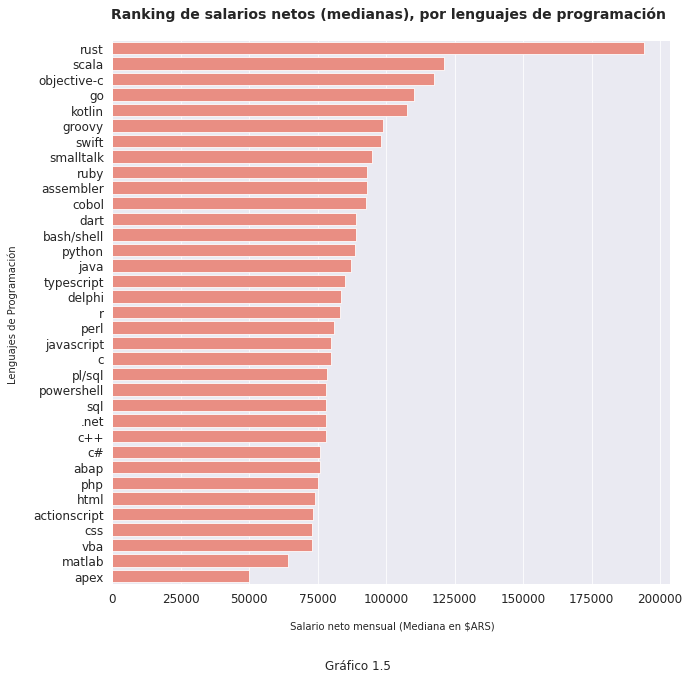

In [29]:
#Tabla de frecuencias
salary_median_by_lang = {}
for lang in lang_columns:
  median_salary = df[df[lang]==1]['salary_monthly_NETO'].median()
  freq = len(df[df[lang]==1])
  salary_median_by_lang.update({lang: [median_salary, freq]})
df2 = pd.DataFrame(list(salary_median_by_lang.items()), columns=['Language','Median_Salary_and_Freq'])
df2[['Median_Salary','Freq']] = pd.DataFrame(df2.Median_Salary_and_Freq.tolist(), index= df2.index)
df2.drop('Median_Salary_and_Freq', axis=1, inplace=True)
df2 = df2.sort_values(by=['Median_Salary'], ascending=False, ignore_index=True)
display(df2[:10])

# Plot de salarios neto (mediana) por lenguaje de programación
plt.figure(figsize=(10, 10))
seaborn.barplot(x="Median_Salary", y="Language", data=df2, color="salmon" )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Ranking de salarios netos (medianas), por lenguajes de programación \n', fontsize=14, weight='bold')
plt.xlabel("\n Salario neto mensual (Mediana en $ARS)", fontsize=10)
plt.ylabel("Lenguajes de Programación \n", fontsize=10)
plt.annotate('Gráfico 1.5', xy = (0.5, -0.15), xycoords='axes fraction', ha='right', va='center', fontsize=12)

**Observaciones:**

- Según este nuevo ordenamiento, los primeros cinco lenguajes "asociados" o usados por personas con los salarios medianos más altos, son:
  1. Rust
  2. Scala
  3. Objective-c
  4. Go
  5. Kotlin

- Lo que hay que notar es que tal como se observa en la tabla, "Rust" tiene muy pocas observaciones, tal como ocurre con "Objective-C", "Smaltalk" y "Assembler"; dificultando la posibilidad de considerar como "representativo" lo observado.

- También vale en este caso la aclaración realizada con anterioridad, respecto a la posibilidad de que una persona esté representada en distintas barras por haber respondido más de un lenguaje.

- Por último, se visualiza en el gráfico que el rango de la mediana de salarios que va desde \$50.000 a \$200.000; lo cual puede estar influenciado por salarios dolarizados, como vimos anteriormente, y veremos en la sección 3.8.

#### 3.6 Análisis del impacto de los años de experiencia en los lenguajes de programación y en los salarios.

Veamos las frecuencias de la cantidad de años de experiencia en nuestra muestra. Se agrupan los años trabajados en intervalos de tres años, y se ordena el gráfico en función de las frecuencias observadas (de mayor a menor). Se trabaja con las declaraciones de años de experiencia menores a 90 años (incluso un valor conservador) para que tenga sentido empírico.


Text(0.5, -0.2, 'Gráfico 1.6')

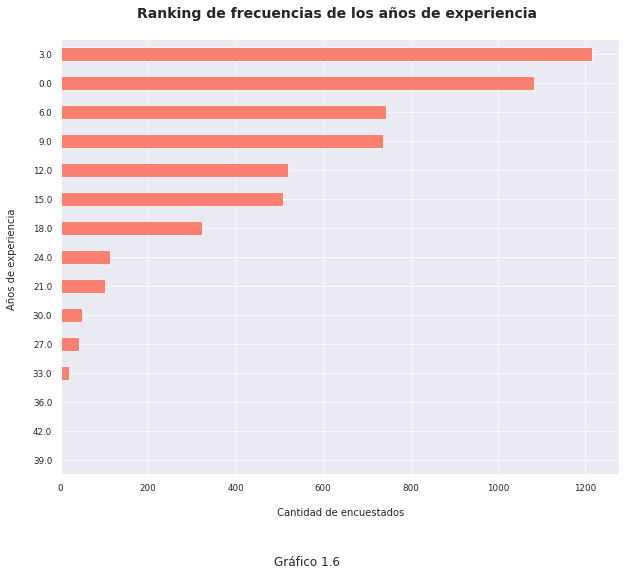

In [30]:
plt.figure(figsize=(10, 8))
df_year_experience = df[df['profile_years_experience']<90]
df_year_experience['profile_years_experience'].\
    apply(lambda x: 3 * (x // 3)).\
    value_counts(sort=True, ascending=True).\
    tail(20).plot.barh(color = "salmon")\
    .set_title('Ranking de frecuencias de los años de experiencia \n ', fontsize=14, weight='bold')
plt.xlabel("\n Cantidad de encuestados", fontsize=10)
plt.ylabel("Años de experiencia \n", fontsize=10)
plt.annotate(
    'Gráfico 1.6', 
    xy = (0.5, -0.2), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

**Observaciones:**

- La mayoría de los encuestados tienen un rango de experiencia de entre 3-6 años, o 0-3 años.

- Sin embargo, si se contabiliza el total de encuestados que tienen más de 6 años de experiencia como un sólo grupo, éste pasa a ser mayoritario.

Veamos ahora un ranking de lenguajes en función de los años promedio de experiencia laboral o "antigüedad" de las personas que los nombraron.

In [31]:
# Años de experiencia (media) vs lenguajes de programación
# Agregar el dato del salario medio del lenguaje y ordenar por mayor experiencia
year_mean_by_lang = {}
for lang in lang_columns:
    mean_years_experience = df[df[lang]==1]['profile_years_experience'].mean()
    median_salary = df[df[lang]==1]['salary_monthly_NETO'].median()
    freq = len(df[df[lang]==1])
    year_mean_by_lang.update({lang: [mean_years_experience, freq, median_salary]})
df3 = pd.DataFrame(list(year_mean_by_lang.items()), columns=['Languajes','Mean_Years_Experience_and_Freq'])
df3[['Mean_Years_Experience','Freq','median_salary']] = pd.DataFrame(df3.Mean_Years_Experience_and_Freq.tolist(), index= df3.index)
df3.drop('Mean_Years_Experience_and_Freq', axis=1, inplace=True)
df3 = df3.sort_values(by=['Mean_Years_Experience'], ascending=False, ignore_index=True)
df3.head(10)

,Languajes,Mean_Years_Experience,Freq,median_salary
0,rust,16.86,14,194000.00
1,perl,16.17,54,81000.00
2,assembler,15.48,27,93000.00
3,delphi,14.58,36,83500.00
4,cobol,14.53,74,92500.00
5,smalltalk,14.06,16,94900.00
6,c,12.06,209,80000.00
7,vba,11.79,208,72750.00
8,actionscript,11.56,31,73400.00
9,c++,11.46,237,78000.00


Text(0.5, -0.15, 'Gráfico 1.7')

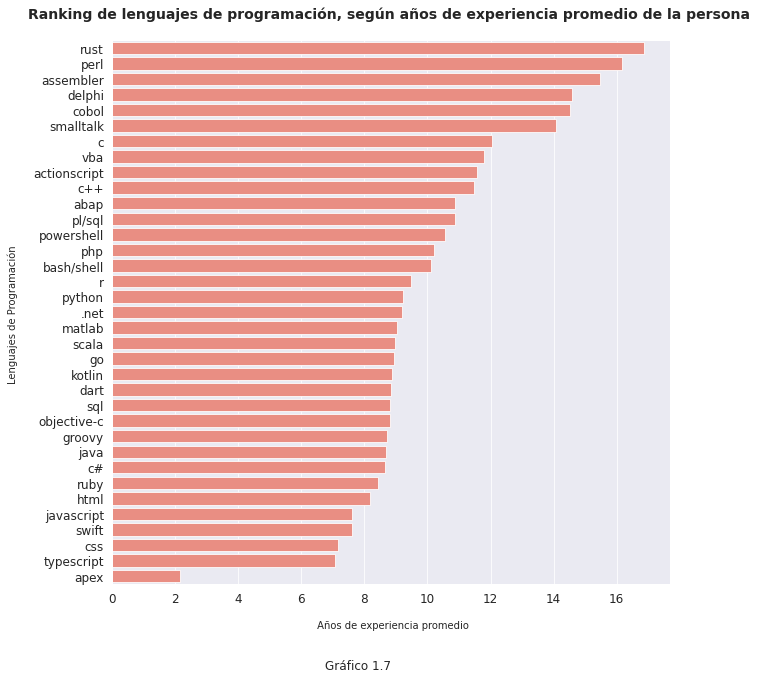

In [32]:
# Plot años de experiencia (media) vs lenguajes de programación y mediana salarial
plt.figure(figsize=(10, 10))
seaborn.barplot(x="Mean_Years_Experience", y="Languajes", data=df3, color="salmon")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Ranking de lenguajes de programación, según años de experiencia promedio de la persona \n', fontsize=14, weight='bold')
plt.xlabel("\n Años de experiencia promedio", fontsize=10)
plt.ylabel("Lenguajes de Programación \n", fontsize=10)
plt.annotate('Gráfico 1.7', xy = (0.5, -0.15), xycoords='axes fraction', ha='right', va='center', fontsize=12)

Para complementar el gráfico anterior, buscamos ver en el siguiente la relación entre las medianas de los salarios netos por lenguaje, y el promedio de los años de experiencia por lenguaje.

Text(0.5, -0.15, 'Gráfico 1.8')

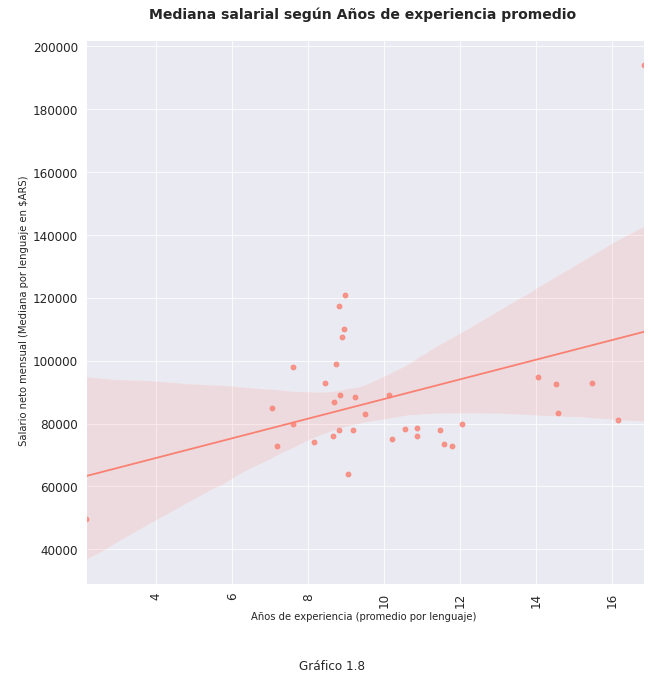

In [33]:
# Plot años de experiencia (media) vs mediana salarial
plt.figure(figsize=(10, 10))
seaborn.regplot(x="Mean_Years_Experience", y="median_salary", data=df3, color="salmon")
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.title('Mediana salarial según Años de experiencia promedio \n', fontsize=14, weight='bold')
plt.ylabel("\n Salario neto mensual (Mediana por lenguaje en $ARS)", fontsize=10)
plt.xlabel("Años de experiencia (promedio por lenguaje) \n", fontsize=10)
plt.annotate('Gráfico 1.8', xy = (0.5, -0.15), xycoords='axes fraction', ha='right', va='center', fontsize=12)

**Observaciones (Gráficos 1.7 y 1.8):**

- Los lenguajes nombrados por personas con mayor promedio de años de experiencia son:

  1. Rust
  2. Perl
  3. Assembler
  4. Delphi
  5. Cobol

* Nuevamente vale aquí la aclaración respecto a la poca cantidad de ocurrencias visible en algunos de estos lenguajes, y el hecho general de que las respuestas de lenguajes NO son excluyentes (una persona con cierta cantidad de años de experiencia laboral, puede usar más de un lenguaje a la vez al momento de responder la encuesta).

* Algo a destacar del gráfico 1.7, es que se observan en los primeros lugares del ranking de lenguajes (según años de experiencia promedio), algunos lenguajes que también se ubicaban en los primeros lugares cuando considerábamos el ranking de lenguajes por personas con "mejores salarios" ("Rust", por ejemplo figuraba como el lenguaje con personas mejores pagas, y coincide con ser el que presenta personas con mayor cantidad de años de experiencia promedio).

* Por otro lado, en el gráfico 1.8 se busca ver la relación entre la "mediana de los salarios netos" y los "años de experiencia" de las personas encuestadas. Lo que se observa en el centro del gráfico, es que no habría mucha relación trabajando los datos de esta manera (agrupados por lenguajes, y considerando que los lenguajes no son excluyentes entre sí!). Lo que se podría destacar quizá en el gráfico, es la situación de los extremos. En donde vemos que hay una mediana salarial muy baja, para una experiencia muy baja en años promedio, y por el otro, una mediana salarial muy alta, para una cantidad de años de experiencia muy superior. De todas formas, como aclaramos, también en estos valores de años de experiencia está jugando el tema de la cantidad de datos de cada subrgupo, lo cual puede influenciar.

* En función de ambas observaciones, cabe preguntarnos si ¿se estará poniendo en juego aquí una relación entre salarios altos, y ciertos lenguajes, influenciada por la antigüedad de las personas que los utilizan? ¿o quizá también por una cuestión de mercado relacionada con la poca cantidad de informáticos que trabajan actualmente con esos lenguajes? Tema que dejamos para analizar en mayor profundidad, cuando contemos con mayores herramientas para ello.


#### 3.7 Análisis del impacto de las actividades principales de las compañías en el salario neto.

A continuación se observan las frecuencias de cada categoría que describe la actividad principal de la compañía para la cual trabajan los empleados/as TI de la muestra.

Tabla de frecuencias de la variable Actividad Principal: 



Servicios / Consultoría de Software / Digital    1925
Producto basado en Software                      1909
Otras industrias                                 1626
Name: company_main_activity, dtype: int64

Text(0.5, -0.35, 'Gráfico 1.9')

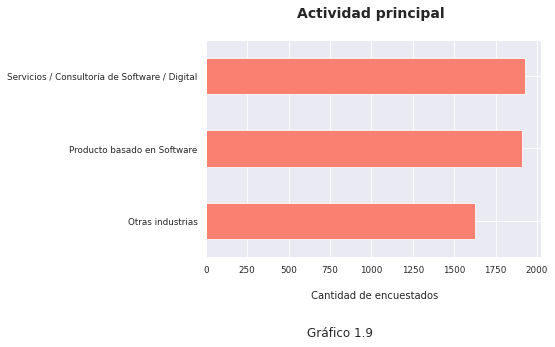

In [34]:
print ("Tabla de frecuencias de la variable Actividad Principal: \n" )
display(df['company_main_activity'].value_counts())

df['company_main_activity'].value_counts(ascending=True)\
    .plot.barh(color = "salmon")\
    .set_title('Actividad principal \n ', fontsize=14, weight='bold')
plt.xlabel("\n Cantidad de encuestados", fontsize=10)
plt.annotate(
    'Gráfico 1.9', 
    xy = (0.5, -0.35), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

**Observaciones:**

- Se visualiza que la muestra está distribuída de forma bastante proporcional entre las tres categorías.

- Siendo "Servicios / Consultoría de Software / Digital" la principal actividad por muy pocos casos. Por lo tanto no creemos relevante realizar una análisis del impacto de ésta variable en los salarios de los lenguajes.

#### 3.8 Analisis de salarios por lenguajes de programación, **en la sub-población "no dolarizados"**.

- Se pretende observar los lenguajes de programación "mejores pagos" si sólo no quedamos con los casos que registran salarios en pesos. Reducimos ahora nuestro dataset, filtrando los casos que cumplen:
    - Personas con un salario neto mayor al salario mínimo a la fecha de la encuesta (i.e > $16.875), y menores a $300.000 (situación hasta ahora).
    - Personas cuyo salario neto no está dolarizado (novedad).

In [35]:
print("Tamaño del dataset antes de remover los salarios dolarizados: %i \n" % len(df))
df_pesos = df[df['salary_in_usd'].isna()]
print("Tamaño del dataset después de remover los salarios dolarizados: %i \n" % len(df_pesos))
df_pesos.reset_index(drop=True, inplace=True)

Tamaño del dataset antes de remover los salarios dolarizados: 5460 

Tamaño del dataset después de remover los salarios dolarizados: 4993 



##### ¿Cuáles son los lenguajes de programación asociados a los mejores salarios (no dolarizados)?

- Establecemos el ranking de lenguajes de programación, en función de la mediana de los salarios netos en pesos que cobran quienes respondieron utilizar dichos lenguajes.

- Recordar que en este análisis una persona, con un sueldo determinado, puede responder que utiliza más de un lenguaje. Y por ende, su salario puede formar parte de las distintas distribuciones de sueldo por lenguajes.

Text(0.5, -0.15, 'Gráfico 1.10')

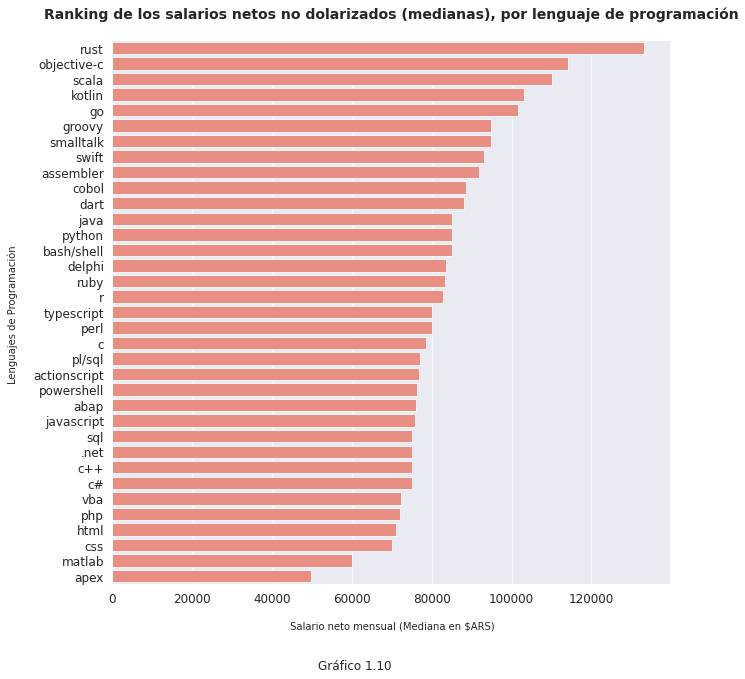

In [36]:
salary_mean_by_lang = {}
for lang in lang_columns:
    mean_salary = df_pesos[df_pesos[lang]==1]['salary_monthly_NETO'].median()
    freq = len(df_pesos[df_pesos[lang]==1])
    salary_mean_by_lang.update({lang: [mean_salary, freq]})
df4 = pd.DataFrame(list(salary_mean_by_lang.items()), columns=['Languajes','Mean_Salary_and_Freq'])
df4[['Mean_Salary','Freq']] = pd.DataFrame(df4.Mean_Salary_and_Freq.tolist(), index= df4.index)
df4.drop('Mean_Salary_and_Freq', axis=1, inplace=True)
df4 = df4.sort_values(by=['Mean_Salary'], ascending=False, ignore_index=True)
# Plot de Salarios neto promedio por lenguaje de programación
plt.figure(figsize=(10, 10))
seaborn.barplot(x="Mean_Salary", y="Languajes", data=df4, color="salmon")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Ranking de los salarios netos no dolarizados (medianas), por lenguaje de programación\n', fontsize=14, weight='bold')
plt.xlabel("\n Salario neto mensual (Mediana en $ARS)", fontsize=10)
plt.ylabel("Lenguajes de Programación \n", fontsize=10)
plt.annotate('Gráfico 1.10', xy = (0.5, -0.15), xycoords='axes fraction', ha='right', va='center', fontsize=12)

**Observaciones:**

- El rango de mediana salarial se acotó a \$50.000-\$130.000 pesos aproximadamente, mientras que en el caso en que también se contabilizaban los sueldos dolarizados el rango era mayor como era de esperar, iba de \$50.000-\$200.000 pesos (Sección 3.5).

- Volviendo a la pregunta inicial del ejercicio 1: "¿Cuáles son los lenguajes de programación asociados a los mejores salarios?", podemos ver que el orden de los lenguajes, según las medianas de los salarios no dolarizados de quienes los usan, tuvo una leve variación respecto a la situación que contemplaba el cobro en dólares, pero el top five sigue entre:
  1. Rust
  2. Objective-c
  3. Scala
  4. Kotlin
  5. Go

#### 3.9 Analisis de salarios por lenguajes de programación, **en la sub-población "no dolarizados y trabajo full-time"**

- Se pretende observar los lenguajes de programación "mejores pagos" si sólo nos quedamos con los casos que registran salarios en pesos y trabajan Full-Time. Conservamos los casos que cumplen las siguientes condiciones:
    - Personas con un salario neto mayor al salario mínimo a la fecha de la encuesta (i.e > $16.875), y menores a $300.000 (situación hasta ahora).
    - Personas cuyo salario neto no está dolarizado (novedad).
    - Personas cuyo trabajo es full-time (novedad).

In [37]:
full_time = df.work_contract_type.isin(['Full-Time'])
print("Tamaño del dataset antes de quedarnos sólo con los Full-Time: %i \n" % len(df_pesos))
df_pesos_fulltime = df[full_time]
print("Tamaño del dataset después de quedarnos sólo con los Full-Time: %i \n" % len(df_pesos_fulltime))
df_pesos_fulltime.reset_index(drop=True, inplace=True)

Tamaño del dataset antes de quedarnos sólo con los Full-Time: 4993 

Tamaño del dataset después de quedarnos sólo con los Full-Time: 4787 



##### ¿Cuáles son los lenguajes de programación asociados a los mejores salarios (no dolarizados y con contrato Full-Time)?

- Establecemos el ranking de lenguajes de programación, en función de las medianas de los salarios netos en pesos que cobran quienes respondieron utilizar dichos lenguajes y tienen contrato Full-Time.

- Recordar que en este análisis una persona, con un sueldo determinado, puede responder que utiliza más de un lenguaje. Y por ende, su salario puede formar parte de las distintas distribuciones de sueldo por lenguajes.

Text(0.5, -0.15, 'Gráfico 1.11')

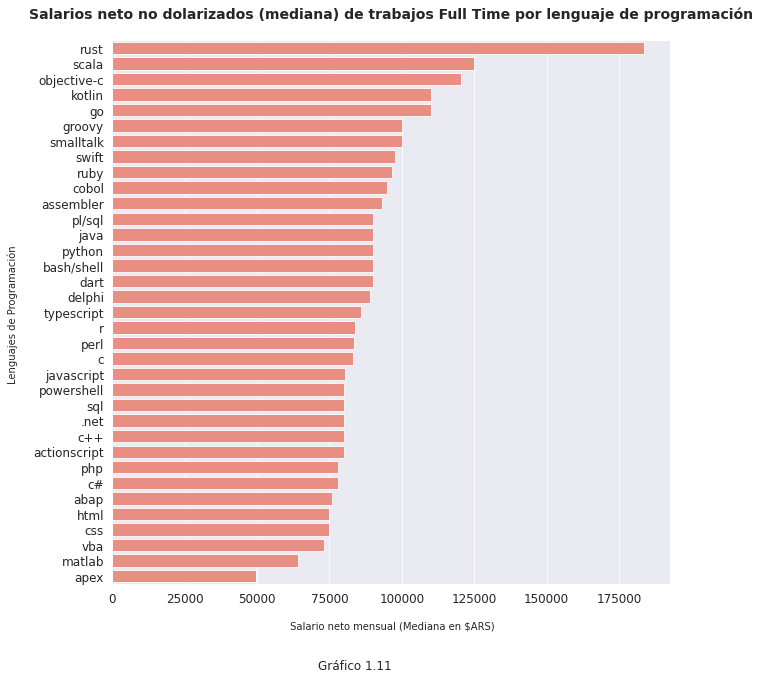

In [38]:
salary_mean_by_lang = {}
for lang in lang_columns:
  mean_salary = df_pesos_fulltime[df_pesos_fulltime[lang]==1]['salary_monthly_NETO'].median()
  freq = len(df_pesos_fulltime[df_pesos_fulltime[lang]==1])
  salary_mean_by_lang.update({lang: [mean_salary, freq]})
df5 = pd.DataFrame(list(salary_mean_by_lang.items()), columns=['Languajes','Mean_Salary_and_Freq'])
df5[['Mean_Salary','Freq']] = pd.DataFrame(df5.Mean_Salary_and_Freq.tolist(), index= df5.index)
df5.drop('Mean_Salary_and_Freq', axis=1, inplace=True)
df5 = df5[~df5['Languajes'].isin(('ninguno', 'ningunodelosanteriores'))]
df5 = df5.sort_values(by=['Mean_Salary'], ascending=False, ignore_index=True)
# Plot de Salarios neto promedio por lenguaje de programación
plt.figure(figsize=(10, 10))
seaborn.barplot(x="Mean_Salary", y="Languajes", data=df5, color="salmon")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Salarios neto no dolarizados (mediana) de trabajos Full Time por lenguaje de programación\n', fontsize=14, weight='bold')
plt.xlabel("\n Salario neto mensual (Mediana en $ARS)", fontsize=10)
plt.ylabel("Lenguajes de Programación \n", fontsize=10)
plt.annotate('Gráfico 1.11', xy = (0.5, -0.15), xycoords='axes fraction', ha='right', va='center', fontsize=12)

**Observaciones:**

- El rango de salarios subió a \$50.000-\$180.000 pesos aproximadamente, mientras que en el caso en que también se contabilizaban los casos no Full-Time, el rango era menor, iba de \$50.000-\$130.000. Ésto era de esperarse, ya que como vimos en la sección 2.3 de análisis de trabajos Full-Time vs Part-Time y Otros, la mediana de los sueldos full-time es mayor a las del resto.

- Volviendo a la pregunta inicial del ejercicio 1: "¿Cuáles son los lenguajes de programación asociados a los mejores salarios?", podemos ver que el orden de los lenguajes mejores pagos tuvo una leve variación, pero el top five sigue entre:
  1. Rust
  2. Scala 
  3. Objective-c
  3. Kotlin
  5. Go

### 3.10 Análisis de asociación entre salario neto y lenguajes de programación desarrollados exclusivamente para Apple.

Enfocaremos el análisis de los lenguajes cuyas personas tienen los mejores salarios, pensando que aquellas personas que utilizan lenguajes de programación desarrollados específicamente para plataformas Apple (Objective-c y Swift), tienen mayor probabilidad de tener mejores salarios.

Para este caso también replanteamos la pregunta:
> ¿Qué conjunto de lenguajes (clasificados esta vez en Apple y No Apple) están asociados a los mejores salarios?

Vale aclarar en este caso, que el dataframe utilizado para este análisis sí considera las respuestas de lenguajes de forma excluyente. Esto es así porque se utilizó el conjunto de datos con variables dummies por lenguaje, y se agregó una última columna que indica "Apple" para laa personas que utilizan ese lenguaje, y "No Apple" para las que no. 

In [39]:
# clasificación de lenguajes en apple - no apple:
is_apple = df['swift'] | df['objective-c']
df['uses_lang_for_apple'] = numpy.where(is_apple, "Apple", "No Apple")
df.head()

,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,tools_work_pc_os,work_contract_type,tools_frameworks,profile_years_experience,salary_satisfaction,company_main_activity,salary_in_usd,work_role,work_years_in_company,profile_gender,profile_age,profile_studies_level,salary_is_usd_cat,.net,abap,actionscript,apex,assembler,bash/shell,c,c#,c++,cobol,css,dart,delphi,go,groovy,html,java,javascript,kotlin,matlab,objective-c,perl,php,pl/sql,powershell,python,r,ruby,rust,scala,smalltalk,sql,swift,typescript,vba,uses_lang_for_apple
0,Ninguno,43000.00,53000.00,GNU/Linux,Full-Time,Ninguno,3.00,1,Servicios / Consultoría de Software / Digital,NaN,Consultant,3.00,Mujer,26,Universitario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Apple
1,"HTML, Javascript, Python",63000.00,79000.00,GNU/Linux,Full-Time,"Django, jQuery",5.00,2,Otras industrias,NaN,Developer,2.00,Hombre,29,Universitario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,No Apple
2,Ninguno,127000.00,160000.00,Windows,Full-Time,Ninguno,2.00,3,Otras industrias,NaN,Infosec,0.00,Mujer,22,Secundario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,No Apple
3,"Bash/Shell, C, CSS, HTML, Java, Javascript, PH...",102000.00,130000.00,GNU/Linux,Full-Time,"jQuery, WordPress",15.00,3,Otras industrias,NaN,SysAdmin / DevOps / SRE,15.00,Hombre,39,Posgrado,Mi sueldo es en pesos,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,No Apple
4,"CSS, HTML, Javascript, SQL, TypeScript",106000.00,140000.00,macOS,Full-Time,"Angular, Node.js",9.00,1,Servicios / Consultoría de Software / Digital,NaN,Developer,6.00,Hombre,32,Universitario,Mi sueldo es en pesos,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,No Apple


In [40]:
df['uses_lang_for_apple'].value_counts()

No Apple    5359
Apple        101
Name: uses_lang_for_apple, dtype: int64

Siendo que la muestra de los programadores para Apple no es grande pero es significativa (más de 100 casos), podemos sacar ciertas conclusiones de la visualizacion siguiente.

Text(0.5, -0.25, 'Gráfico 1.12')

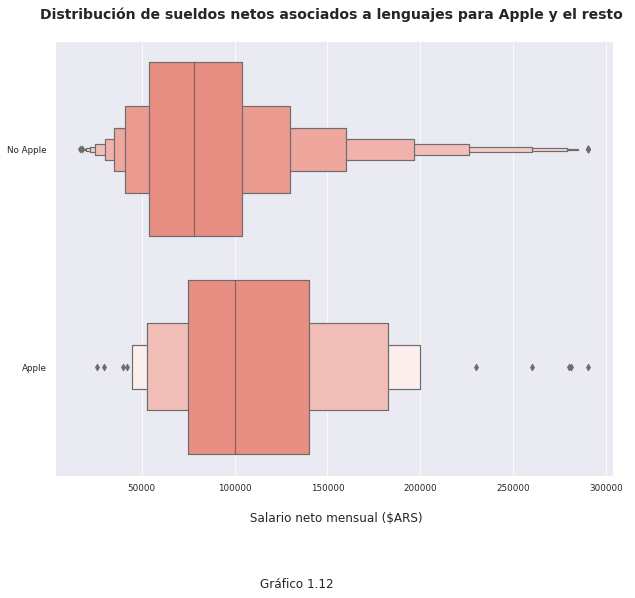

In [41]:
fig = plt.figure(figsize=(10, 8))
g = seaborn.boxenplot(
    data=df, 
    x='salary_monthly_NETO',
    y='uses_lang_for_apple',
    color='salmon'
)

plt.title('Distribución de sueldos netos asociados a lenguajes para Apple y el resto \n', fontsize=14, weight='bold')
plt.xlabel("\n Salario neto mensual ($ARS)")
plt.ylabel("", fontsize=10)
plt.annotate(
    'Gráfico 1.12', 
    xy=(0.5, -0.25), 
    xycoords='axes fraction', 
    ha='right', 
    va='center', 
    fontsize=12
)

**Observaciones**  
- La mediana de salarios de aquellas personas que programan en lenguajes específicos para Apple, es mayor a la mediana de salario de aquellos que programan en el resto de los lenguajes.

- Los lenguajes desarrollados para Apple, es decir: **Swift y Objective-c** están asociados a mejores salarios que los lenguajes "no Apple".

**ACLARACIÓN: Para los siguientes análisis no se utilizará el dataframe convertido a One Hot encoding (df), si no que se trabajará con la función propuesta en clase (filtered_df_lang).**

Las siguientes celdas de código separan estos lenguajes de programación.

In [42]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]
  #return [lang.strip()
  #        for lang in languages_str.split(',')]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.

# Frecuencia de lenguajes para quedarnos con los de freq. > 10
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
df_lang['frequency_programming_language'] = df_lang \
  .groupby('programming_language')['programming_language'] \
  .transform('count')
df_lang['normalized_frequency_programming_language'] = df_lang \
  .groupby('programming_language')['programming_language'] \
  .transform('count') / len(df_lang)
# Nos quedamos con los lenguajes con freq. > 10
interesting_languages = language_count[language_count['frequency'] > 10]['language']
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
# Eliminamos los casos 'ninguno'
filtered_df_lang = filtered_df_lang[~filtered_df_lang.programming_language.isin(['ninguno'])]
filtered_df_lang.programming_language.nunique() # Verificamos que tiene 35 lenguajes, igual que el df one_hot

35

En la columna `programming_language` se encuentra cada lenguaje por separado. Notar que si una respuesta contenía 3 lenguajes, como `"HTML, Javascript, Python"`, la fila ha sido replicada 3 veces. Por ello, hay tres filas con índice 1.

### 3.11 Análisis de asociación entre salario neto y lenguajes de programación populares, clasificados por rol de trabajo (`work_role`).

Se plantea ahora analizar los lenguajes de programación, agrupados por área de trabajo basada en la variable "work role", ya que consideramos que el salario no se asocia únicamente a un lenguaje, sino que se vincula con un conjunto de ellos.

Para esto nos replanteamos la pregunta:
  
  > ¿Qué conjunto de lenguajes (observados por áreas de trabajo), están asociados a los mejores salarios? 
  
  > Una vez que tenemos los roles mejores pagos (que cobran por encima de la media), ver cuáles son los lenguajes de esos roles.

Si orientamos la investigacion a que sea vista por "aspirantes a programación", es conveniente catalogar los distintos roles según el tipo de trabajo, para que se tenga una mejor idea de la variedad de puestos y ubicar así el valor de cada rol según el sueldo.

**¿Cómo nos interesa clasificar los roles?**

In [43]:
# Casos distintos para 'work_role'
len(df['work_role'].value_counts())

298

En primer lugar, vemos que la columna `work_role` muestra una situación similar al caso de los lenguajes: hay una gran variedad  de respuestas dentro de los roles disponibles (298).

Por lo tanto, para simplificar, y tomar sólo los datos significativos, tomamos aquellos roles que se repiten más de 10 veces, y graficamos sus frecuencias a continuación (se los representa en escala logarítmica).

Text(0.5, -0.2, 'Gráfico 1.13')

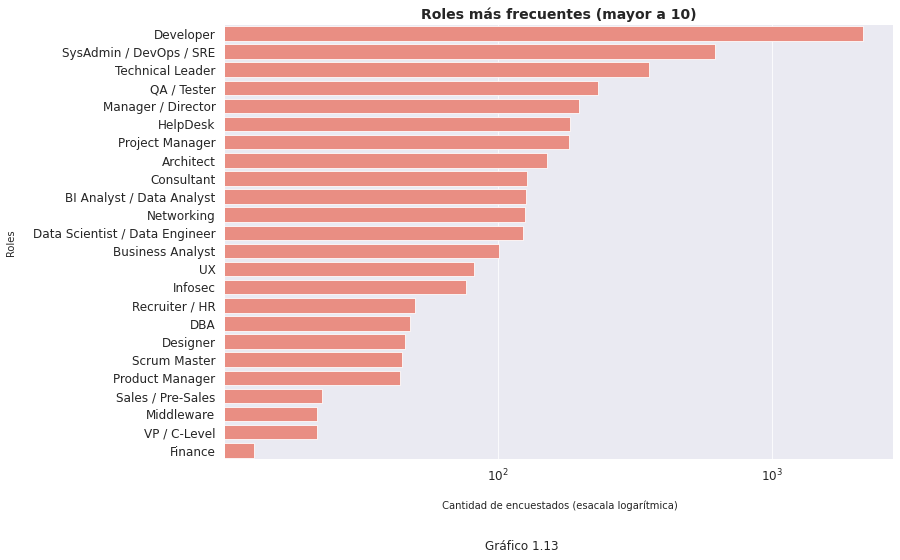

In [44]:
# Plot de frecuencia de roles
df_roles_count=df['work_role'].value_counts().reset_index().rename(columns={'index':'work_role', 'work_role':'frequency'})
fig = plt.figure(figsize=(12, 8))
g = seaborn.barplot(data=df_roles_count[df_roles_count['frequency'] > 10], x='frequency', y='work_role', color='salmon')
# Log scale
g.set_xscale("log")
plt.title("Roles más frecuentes (mayor a 10)", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("\n Cantidad de encuestados (esacala logarítmica)", fontsize=10)
plt.ylabel("Roles \n", fontsize=10)
plt.annotate('Gráfico 1.13', xy = (0.5, -0.2), xycoords='axes fraction', ha='right', va='center', fontsize=12)

**Observar:**

- Existen muchas áreas donde un programador puede trabajar. En esta encuesta la mayor cantidad de casos está concentrada en roles TI.

- En este sentido agrupamos diferentes roles en perfiles: 

  > ** Perfil de Desarrollo:**
    - Developer
    - SysAdmin / DevOps / SRE
    - QA / Tester
    - Consultant
    - Designer

  > ** Perfil de Liderazgo**
    - Manager / Director
    - Architect
    - Project Manager
    - Technical leader
    - Scrum Master

  > ** Perfil de Analisis de negocio**
    - BI Analyst / Data Analyst
    - Data Scientist / Data Engineer

  > ** Perfil de Soporte**
    - DBA
    - Networking
    - HelpDesk

Generamos una nueva columna `'perfiles_cat'` que contendrá los perfiles asociados a cada rol.

In [45]:
# Detalle técnico: renombramos todos los business analyst a BI Analyst / Data Analyst porque son lo mismo

filtered_df_lang.loc[df['work_role'] == "Business Analyst", 'work_role'] = "BI Analyst / Data Analyst"

perfiles={
    "perfiles_dev" : [
         "Developer",
         "SysAdmin / DevOps / SRE",
         "QA / Tester",
         "Consultant",
         "Designer"
    ],
    "perfiles_lead" : [
        "Manager / Director",
        "Architect",
        "Project Manager",
        "Technical leader",
        "Scrum Master"
    ],
    "perfiles_bi" : [
        "BI Analyst / Data Analyst",
        "Data Scientist / Data Engineer"
    ],
    "perfiles_supp" : [
        "DBA",
        "HelpDesk",
        "Networking"
    ]
}

for index, row in filtered_df_lang.iterrows():
    if row['work_role'] in perfiles['perfiles_dev']:
        filtered_df_lang.at[index,'perfiles_cat'] =  "Desarrollo"
    elif row['work_role'] in perfiles['perfiles_lead']:
        filtered_df_lang.at[index,'perfiles_cat'] =   "Liderazgo"
    elif row['work_role'] in perfiles['perfiles_bi']:
        filtered_df_lang.at[index,'perfiles_cat'] =   "BI / Data Science"
    elif row['work_role'] in perfiles['perfiles_supp']:
        filtered_df_lang.at[index,'perfiles_cat'] =   "Soporte"
    else: row['perfiles_cat'] = "none"

**Análisis: sueldos netos, lenguajes más populares y roles reagrupados**

- Para el análisis se seleccionan los 15 lenguajes de programación más populares, los dos gráficos siguientes muestran:

- Gráfico 1.14 - Los 15 lenguajes más populares (ordenados por cantidad de ocurrencias en cada uno), clasificando dichas ocurrencias por los cuatro roles definidos (Desarrollo, Liderazgo, BI/DS, Soporte). Este gráfico brindará noción de los tamaños de cada grupo.

- Gráfico 1.15 - El ranking de los 15 lenguajes de programación más populares, ordenados ahora en función de la mediana de salarios netos de cada lenguaje, clasificados a su vez dentro de ellos por los cuatro grupos de roles definidos. Este gráfico pretende observar la asociación entre lenguajes populares y mejores salarios netos, observando al mismo tiempo la influencia del rol.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

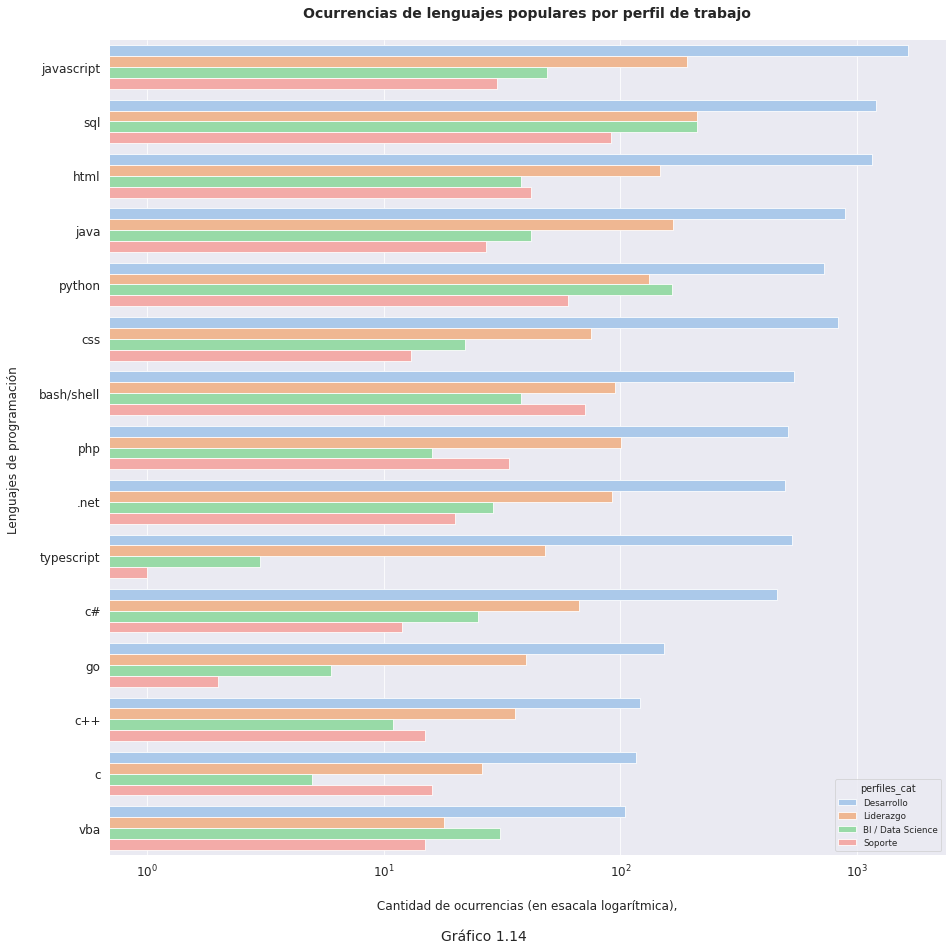

In [46]:
# Los 15 lenguajes mas populares
df_lang_pop = filtered_df_lang            \
                 [                            \
                  filtered_df_lang['programming_language'] \
                    .isin(lang_freq.sort_values(   \
                      'Freq', ascending=False)[0:15]['Language']) 
                 ]

# Gráfico de ncuestados por rol
fig, axes = plt.subplots(nrows=1, figsize=(15, 15))
g = seaborn.countplot(
    data=df_lang_pop[df_lang_pop['perfiles_cat'] != 'no'], 
    hue='perfiles_cat',
    y="programming_language",
    order=df_lang_pop['programming_language'].value_counts().index.tolist()
)
plt.ticklabel_format(style='plain', axis='x')
g.set_xscale('log')
seaborn.despine()
plt.title("Ocurrencias de lenguajes populares por perfil de trabajo\n", fontsize=14, weight='bold')
plt.annotate('Gráfico 1.14', xy = (0.5, -0.1), xycoords='axes fraction', ha='right', va='center', fontsize=14)
plt.xlabel("\n Cantidad de ocurrencias (en esacala logarítmica), ", fontsize=12)
plt.ylabel("Lenguajes de programación \n", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

Text(0.5, -0.1, 'Gráfico 1.15')

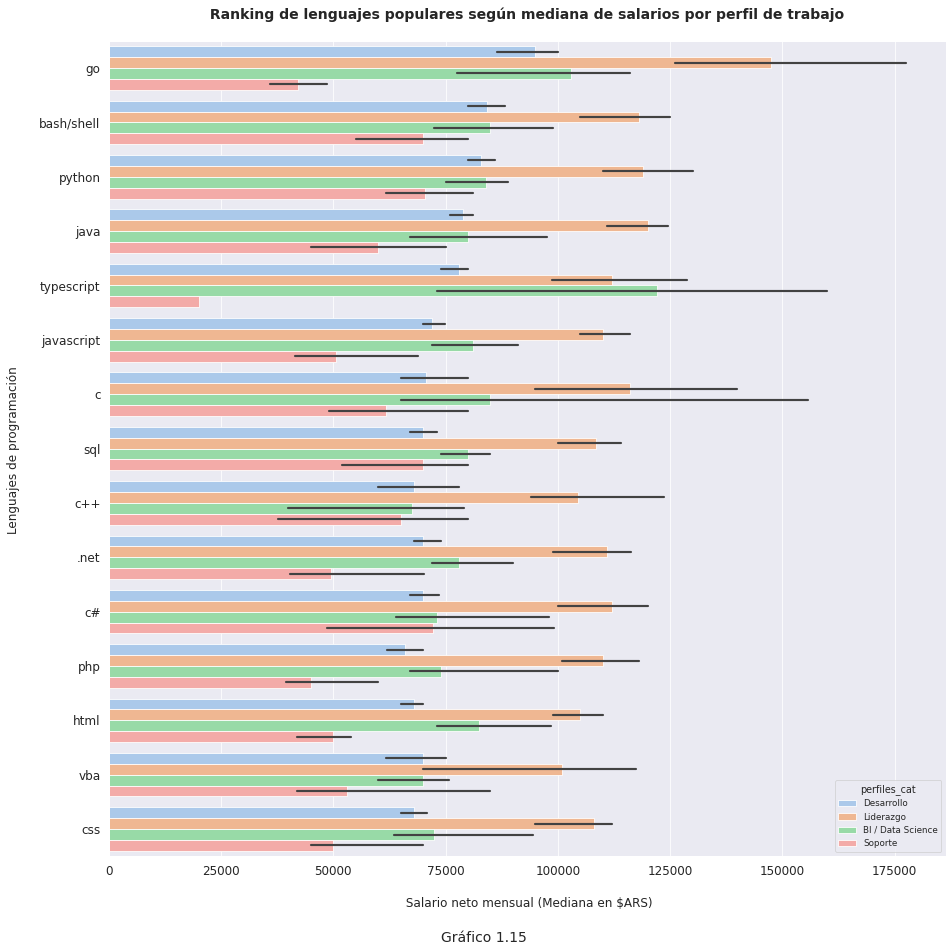

In [47]:
# Gráfico de Ranking de lenguajes populares según mediana de salarios, agrupadas por rol
fig, axes = plt.subplots(nrows=1, figsize=(15, 15))
g = seaborn.barplot(
    data=df_lang_pop[df_lang_pop['perfiles_cat']  != 'no'], 
    x=df_lang_pop['salary_monthly_NETO'],
    hue='perfiles_cat',
    y="programming_language",
    estimator=numpy.median,
    order=df_lang_pop.groupby('programming_language')['salary_monthly_NETO'].median().sort_values(ascending=False).index.tolist()
)
plt.title(" Ranking de lenguajes populares según mediana de salarios por perfil de trabajo \n", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("\n Salario neto mensual (Mediana en $ARS)", fontsize=12)
plt.ylabel("Lenguajes de programación \n", fontsize=12)
plt.annotate('Gráfico 1.15', xy = (0.5, -0.1), xycoords='axes fraction', ha='right', va='center', fontsize=14)

**Observaciones**

-	El lenguaje popular "mejor pago" es “Go”, seguido de "Bash/Shell", "Python" y "Java".

-	Tal como se advirtió en otras representaciones, en estos gráficos una persona con un determinado salario, puede usar más de un lenguaje de programación.

-	De todas formas, al incluir la variable de perfiles en el análisis, se puede observar cierta tendencia general en los datos:

  * Los perfiles de "Liderazgo" tienden a ganar más que el resto independientemente del lenguaje de programación que utilice. Esto es esperable, dado que un líder suele tener más experiencia y/o responsabilidad, y es un recurso más escaso.

  * Los perfiles de "Soporte" están entre los "peores pagos". Aunque no existe una justificación clara para ello, ya que su rol conlleva una alta responsabilidad para mantener en correcto funcionamiento la infraestructura de una empresa.

  * Los perfiles de "Desarrollo" y "BI / Data Science" tienen salarios similares. Esto no necesariamente es esperable, sino que es algo que vemos en esta distribución de datos, por lo que las diferencias se pueden seguir estudiando.

-	Por último, las barras negras representan la variabilidad o errores asociados a los valores centrales estimados. Se deben analizar con precaución los casos en que éstas son muy pronunciadas, ya que puede estar representando una combinación de lenguaje-perfil que no tenga sentido en la práctica (Por ejemplo, el uso de C para el rol de Business Analyst).

### 3.12 Análisis de asociación entre salario neto y lenguajes de programación relacionados a soluciones web.

- Al concentrarnos sólo en los lenguajes relacionados al rubro del desarrollo web, se puede analizar más claramente la distribución de los salarios para cada lenguaje, y ver una posible relación entre lenguajes y salarios netos específicamente dentro de éste sector de la industria (que evidencia una gran proporción en la muestra).

- Definimos los lenguajes que pertenecen al rubro del desarrollo web: "python", "javascript", "sql", "html","java", "css", "php", ".net", "typescript" y "c#".

- Por conocimiento de campo, html y css suelen estar juntos: es muy raro en la industria tener un rol dedicado explusivamente a HTML ó CSS (por este motivo, y por observar mediante un gráfico boxplot (que se omite para evitar extensión) que la distribución de ambos es muy parecida, se decide unificarlos en una sola categoría.

In [48]:
# Definimos los lenguajes que pertenecen al rubro del desarrollo web
web_languages = ["python", "javascript", "sql", "html","java", "css", "php", ".net", "typescript", "c#"]

# Generamos un nuevo dataframe filtrando según los lenguajes web
df_web_lang = df_lang[df_lang.programming_language.isin(web_languages)]

Text(0.5, -0.3, 'Gráfico 1.16')

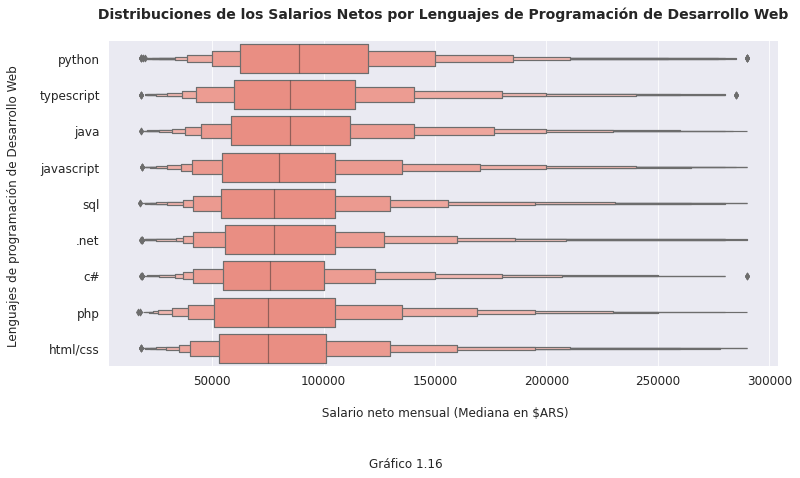

In [49]:
# Para estar segurxs de tomar todos los casos en donde aparezca tanto en uppercase, lowercase o mezclado
html_css_filter_list=["html", "css", "HTML", "CSS", "Html", "Css"]

# Procedemos a transformar la columna `tools_programming_languages` usando la función `filtered_lang_html_or_css`
df_web_lang["tools_programming_languages"]=[filtered_lang_html_or_css(str(x),html_css_filter_list) for x in df_web_lang["tools_programming_languages"]]

# En la columna `tools_programming_languages` ahora aparece el mismo valor HTML/CSS, como un string.

# Ahora debemos hacer lo mismo con la columna `cured_programming_languages`
df_web_lang["cured_programming_languages"]=[cured_lang_html_css(x,html_css_filter_list) for x in df_web_lang["cured_programming_languages"]]


# En la columna `cured_programming_languages` ahora aparece el mismo valor html/css, como un valor de un array.
# Pero ahora debemos actualizar la columna `programming_language` con estos nuevos valores, y asi contabilizarlos en adelante como un solo lenguaje.

df_web = df_web_lang.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
df_web["tools_programming_languages"]=[filtered_lang_html_or_css(str(x),html_css_filter_list) for x in df_web["tools_programming_languages"]]
df_web["cured_programming_languages"]=[cured_lang_html_css(x,html_css_filter_list) for x in df_web["cured_programming_languages"]]

web_languages = ["python", "javascript", "sql", "html/css","java", "php", ".net", "typescript", "c#"]

df_web = df_web[df_web.programming_language.isin(web_languages)]

plt.figure(figsize=(12, 6))
seaborn.boxenplot(data=df_web, x='salary_monthly_NETO', y='programming_language',
                color='salmon', order=df_web.groupby('programming_language')['salary_monthly_NETO'].median().sort_values(ascending=False).index.to_list())
plt.ticklabel_format(style='plain', axis='x')
plt.title(" Distribuciones de los Salarios Netos por Lenguajes de Programación de Desarrollo Web \n", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("\n Salario neto mensual (Mediana en $ARS)", fontsize=12)
plt.ylabel("Lenguajes de programación de Desarrollo Web \n", fontsize=12)
plt.annotate('Gráfico 1.16', xy = (0.5, -0.3), xycoords='axes fraction', ha='right', va='center', fontsize=12)


**Observaciones:**

- En las distribuciones de salarios por lenguajes de programación exclusivos del desarrollo web, se observa un ordenamiento mayor a menor mediana, en donde "Python" tiene el primer lugar en el ranking, y "HTML/CSS" el último.

- Se aprecia en dicho gráfico que el 50% de la distribución central de los salarios de quienes respondieron utilizar estos lenguajes, se encuentran entre valores que van desde aprox. los \$50.000 hasta los  \$120.000.

- Vale aquí aclarar nuevamente que una persona, con un salario, puede utilizar más de un lenguaje; motivo por el cual se pierde la relación unívoca entre salarios y lenguajes, quedando suejetas a esta aclaración las interpretaciones realizadas.

**EJERCICIO 2:** 

En el siguiente notebook llamado "Palas Atenea - AyVdD - Entregable - Parte 1 - Ejercicio 2", se continúa con el entregable 1 -  Ejercicio 2.